In [1]:
# Warning: You must have LaTeX installed

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

# Farnebäck's motion estimation

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [3]:
!which python

/home/vruiz/enviroments/SM/bin/python


In [4]:
!pip install --upgrade pip

In [5]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [6]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [7]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [8]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

In [9]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

In [10]:
try:
    import optical_flow as motion
    import display
    import prediction
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    from motion_estimation import optical_flow as motion
    from motion_estimation import display
    from motion_estimation import prediction

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5
extension mode = 1


In [11]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [12]:
%%bash
if [ -d "$HOME/repos/image_synthesis" ]; then
    cd $HOME/repos/image_synthesis
    echo "$HOME/repos/image_synthesis ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_synthesis.git
fi

/home/vruiz/repos/image_synthesis ... 
Ya está actualizado.


## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but transform coefficients resulting of convolving the following basis fuctions. This decreases the computational requirements the algorithm.

### No motion

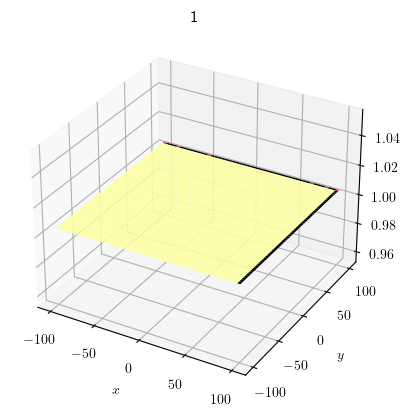

In [13]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

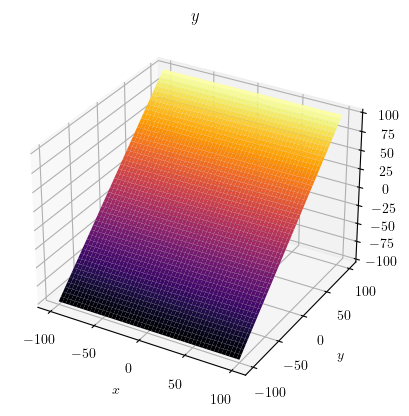

In [14]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

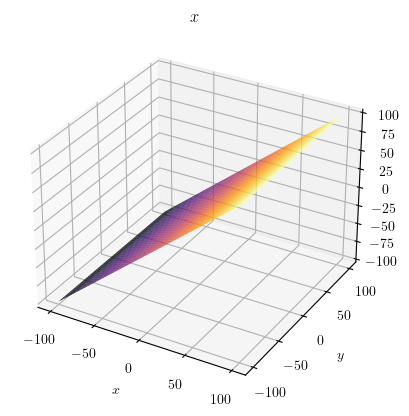

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

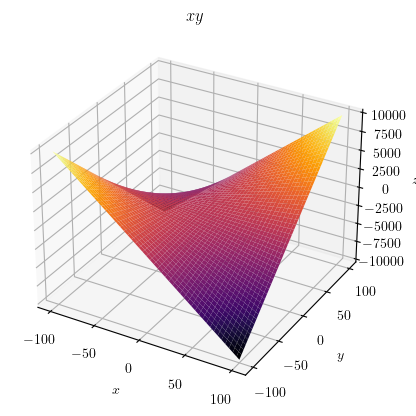

In [16]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

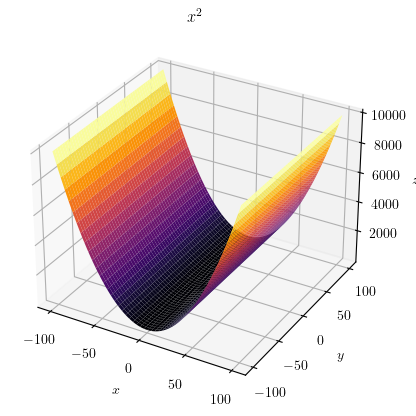

In [17]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

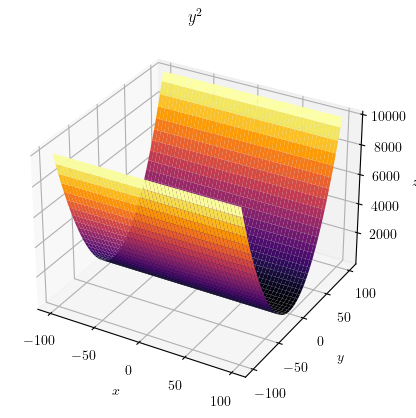

In [18]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Create a moving-circles sequence
There are two circles, moving horizontally in oposite directions.

In [19]:
%%bash
frames=5
~/repos/image_synthesis/moving_circle.sh -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f $frames -d 10
~/repos/image_synthesis/moving_circle.sh -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f $frames -d 10 -a 0 -b -1
set -x
i=0
while [ $i -le $((frames-1)) ]
do
    ii=$(printf "%03d" $i)
    convert -append /tmp/right${ii}.png /tmp/left${ii}.png /tmp/${ii}.png
    i=$(( $i + 1 ))
done
set -x

/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f 5 -d 10
output = /tmp/right
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/right000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 33,16 43,16' -depth 8 /tmp/right001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 34,16 44,16' -depth 8 /tmp/right002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 35,16 45,16' -depth 8 /tmp/right003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 36,16 46,16' -depth 8 /tmp/right004.png
+ i=5
+ '[' 5 -le 4 ']'


/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f 5 -d 10 -a 0 -b -1
output = /tmp/left
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10
Y increment = 0
X increment = -1


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/left000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 31,16 41,16' -depth 8 /tmp/left001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 30,16 40,16' -depth 8 /tmp/left002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 29,16 39,16' -depth 8 /tmp/left003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 28,16 38,16' -depth 8 /tmp/left004.png
+ i=5
+ '[' 5 -le 4 ']'
+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -append /tmp/right000.png /tmp/left000.png /tmp/000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001


## Testing with moving circles (max_abs_motion=1)

In [20]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/001.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/001.png (64, 64, 3) uint8 len=720 max=255 min=0


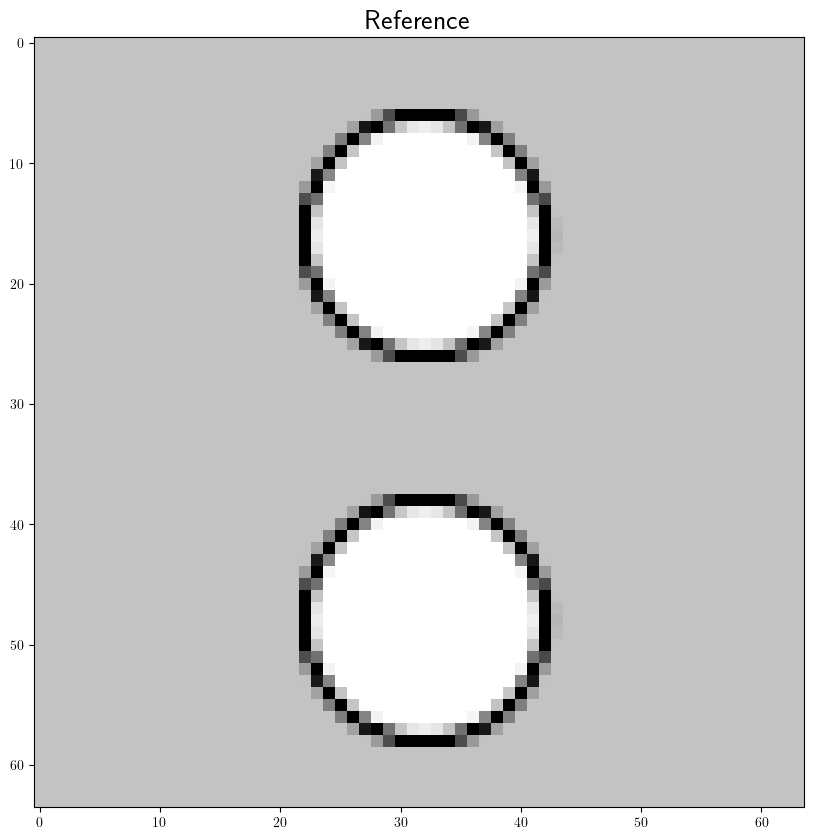

In [21]:
gray_image.show(R_Y, "Reference")

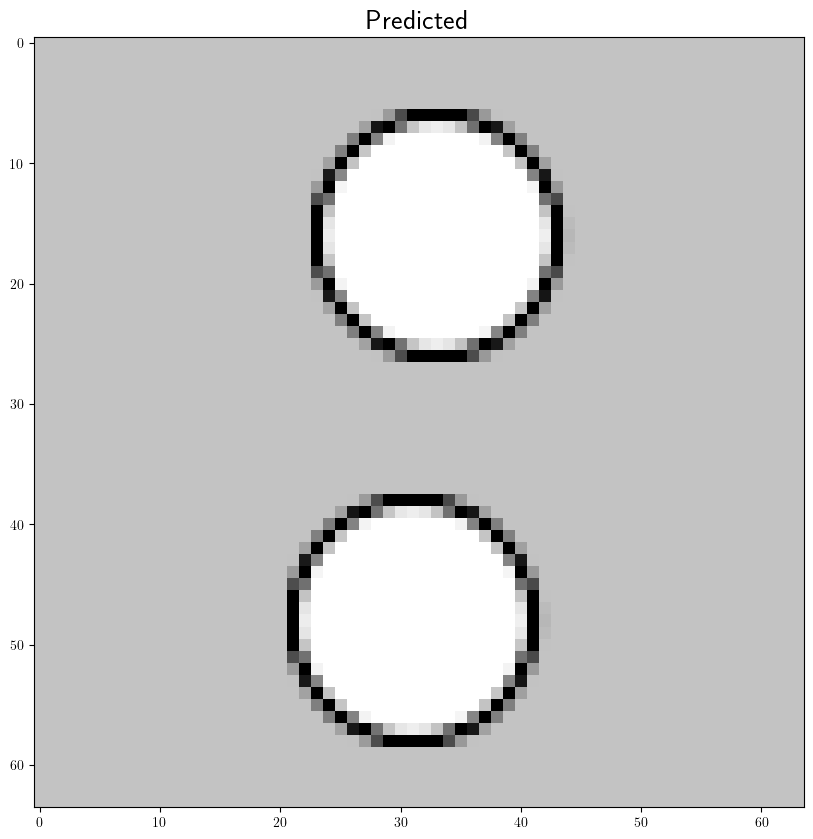

In [22]:
gray_image.show(P_Y, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [23]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

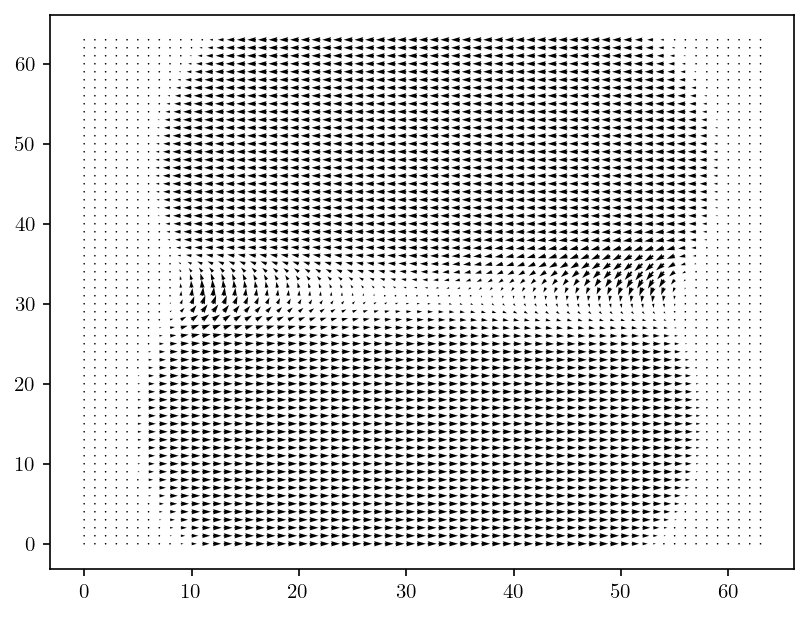

In [24]:
display.show_vectors(MVs[::1, ::1])

In [25]:
hat_P = prediction.make(reference=R, MVs=MVs)

In [26]:
print(R.dtype, MVs.dtype)

uint8 float32


[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.77734375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.49951171875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.4833984375
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.763671875
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.480712890625
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.4619140625
[image_3.py:87 print_stats() INFO] component=0 max=132 min=125 avg=128.013671875
[image_3.py:87 print_stats() INFO] component=1 max=134 min=123 avg=128.018798828125
[image_3.py:87 print_stats() INFO] component=2 max=135 min=123 avg=128.021484375


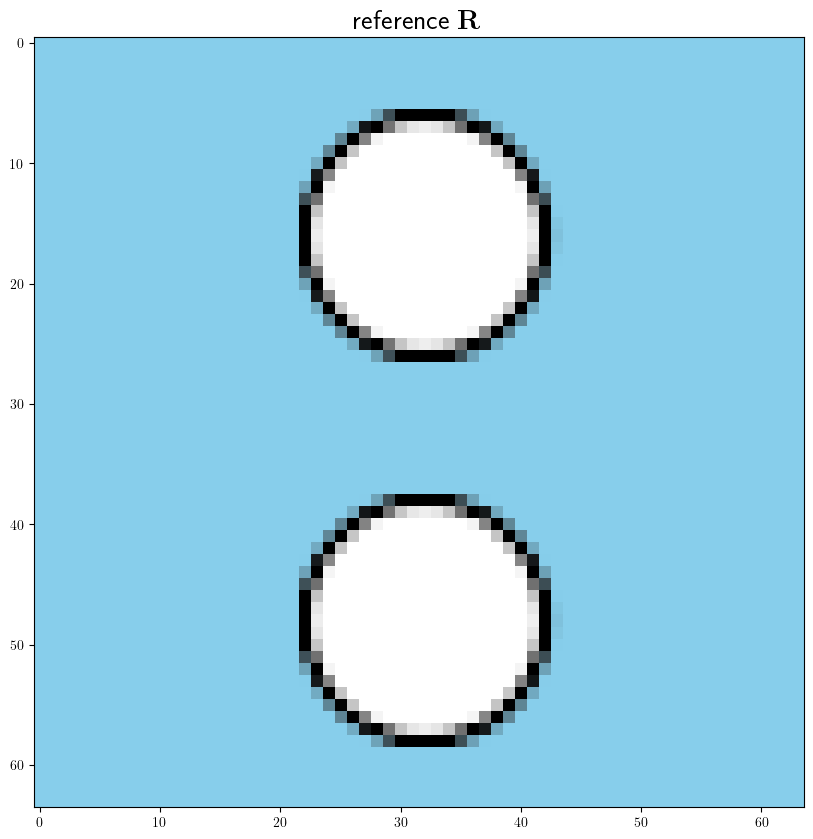

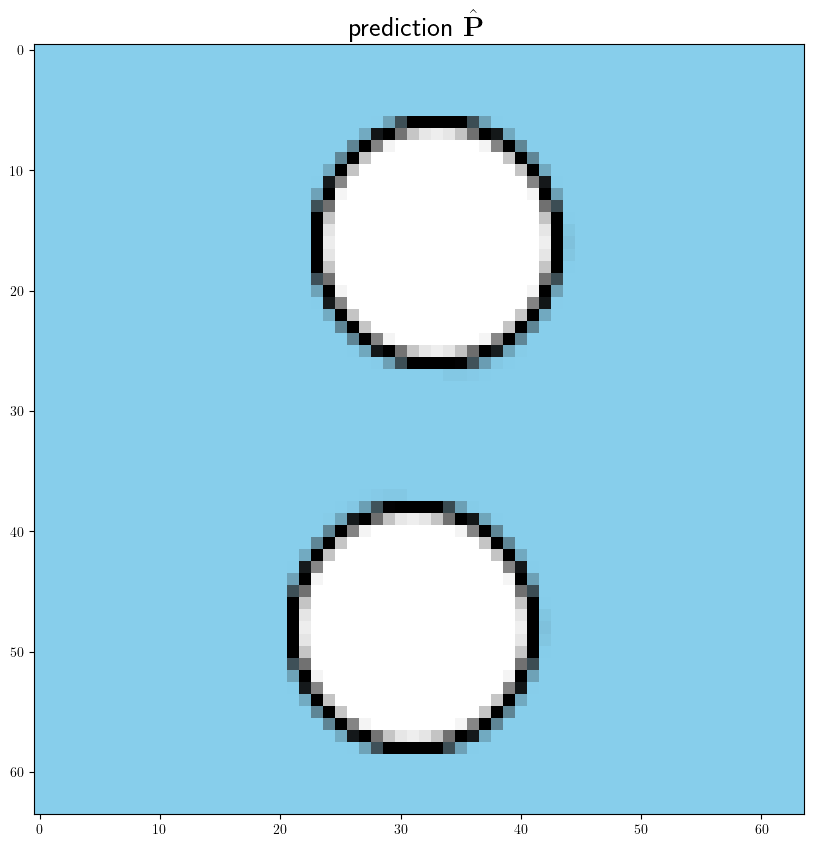

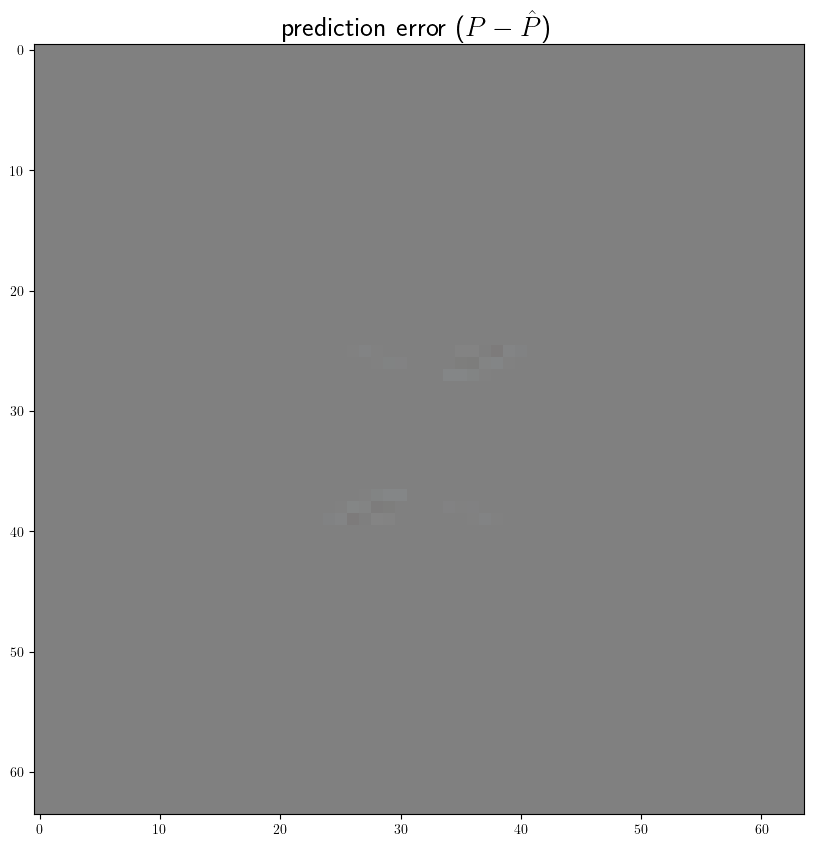

In [27]:
RGB_image.show(R, "reference ${\mathbf R}$")
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [28]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/002.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/002.png (64, 64, 3) uint8 len=720 max=255 min=0


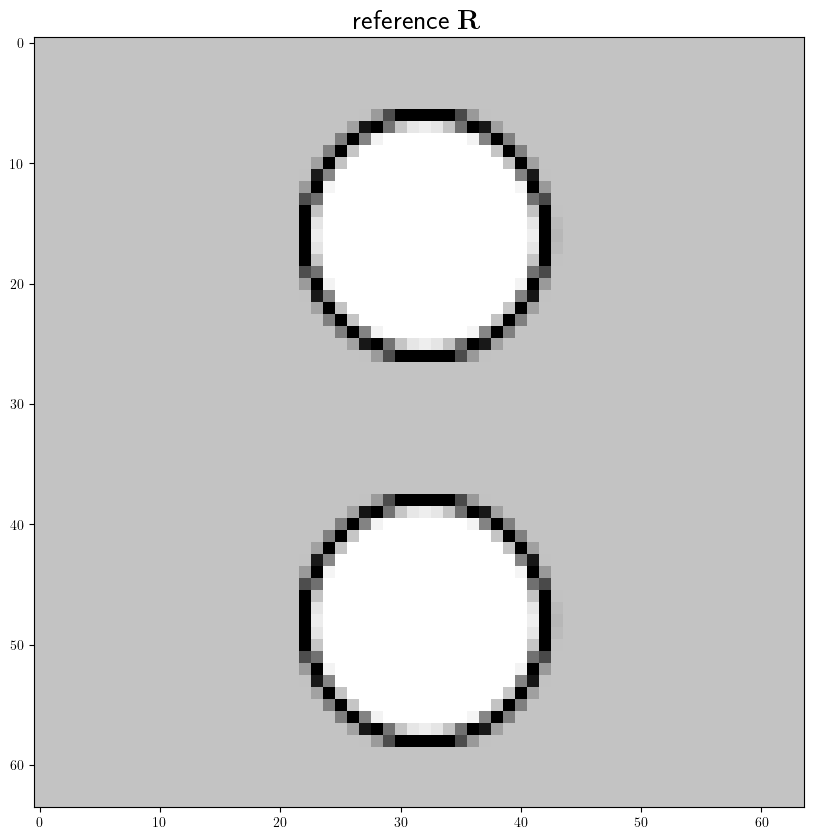

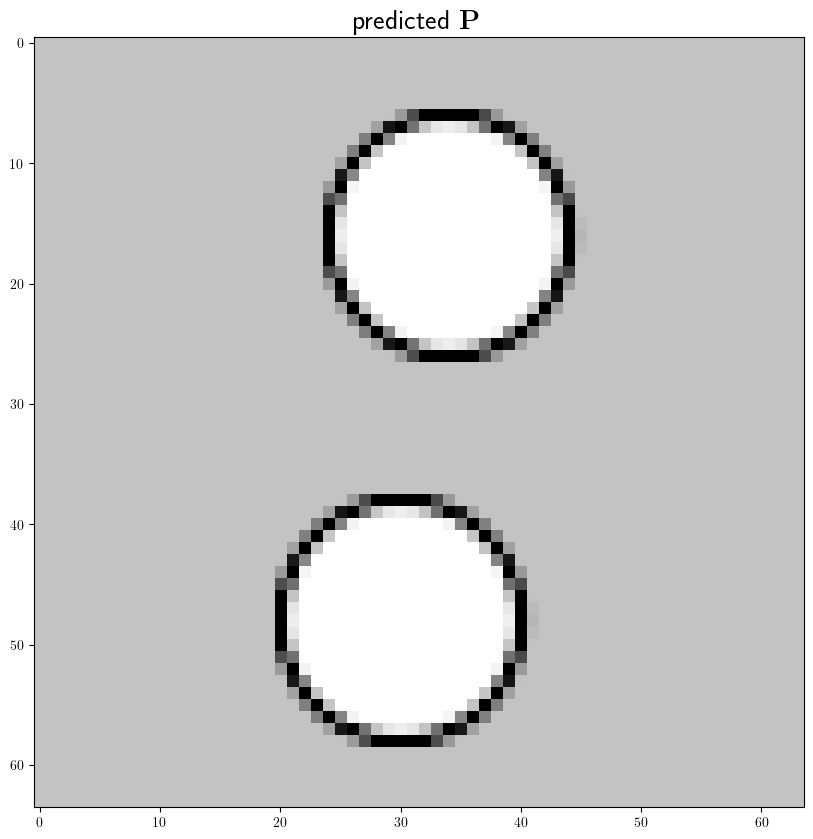

In [29]:
gray_image.show(R_Y, "reference ${\mathbf R}$")
gray_image.show(P_Y, "predicted ${\mathbf P}$")

In [30]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

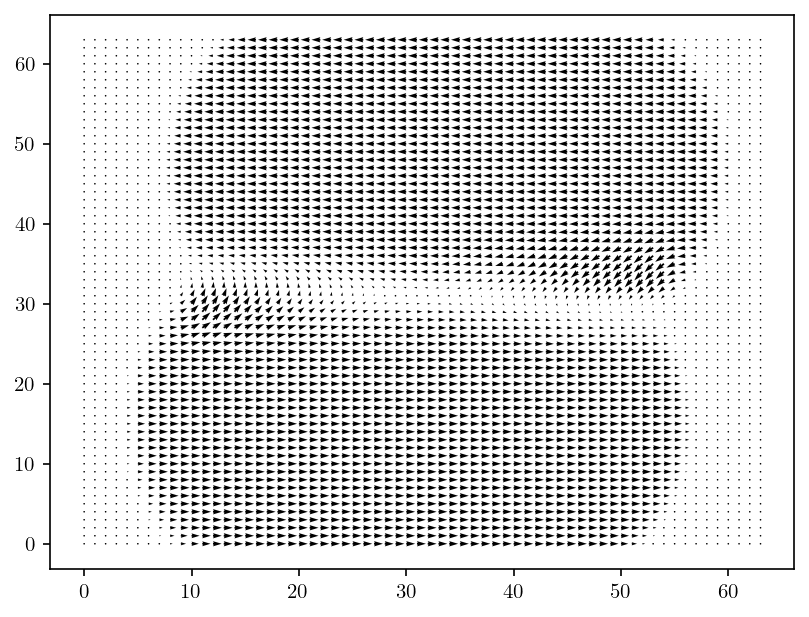

In [31]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.775146484375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.486328125
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.463623046875
[image_3.py:87 print_stats() INFO] component=0 max=136 min=118 avg=128.002197265625
[image_3.py:87 print_stats() INFO] component=1 max=140 min=117 avg=128.01318359375
[image_3.py:87 print_stats() INFO] component=2 max=142 min=117 avg=128.019775390625


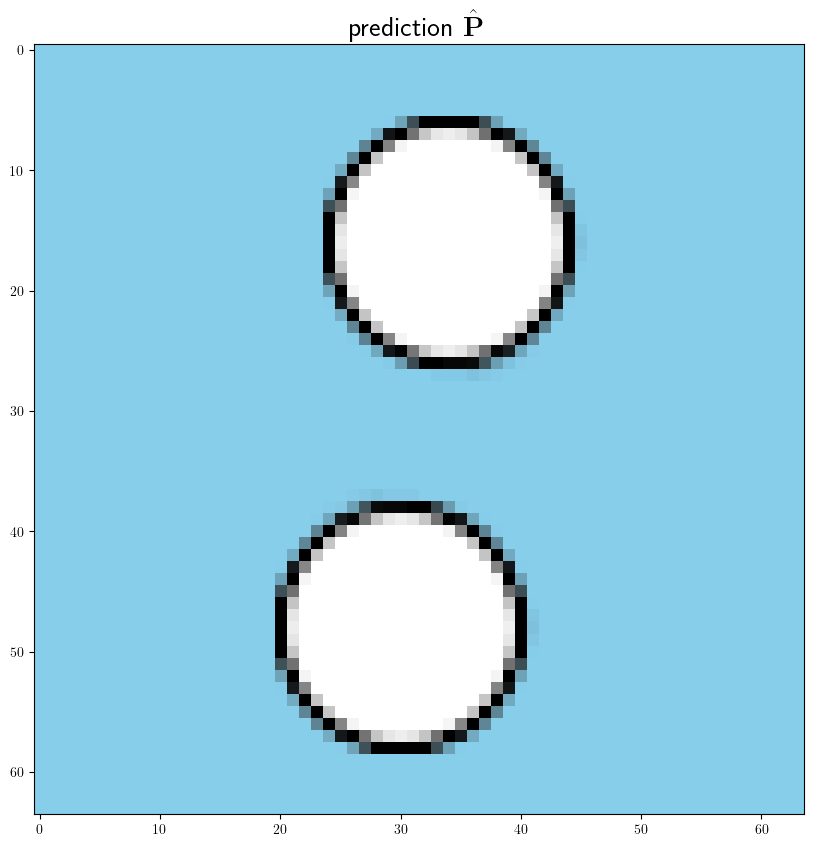

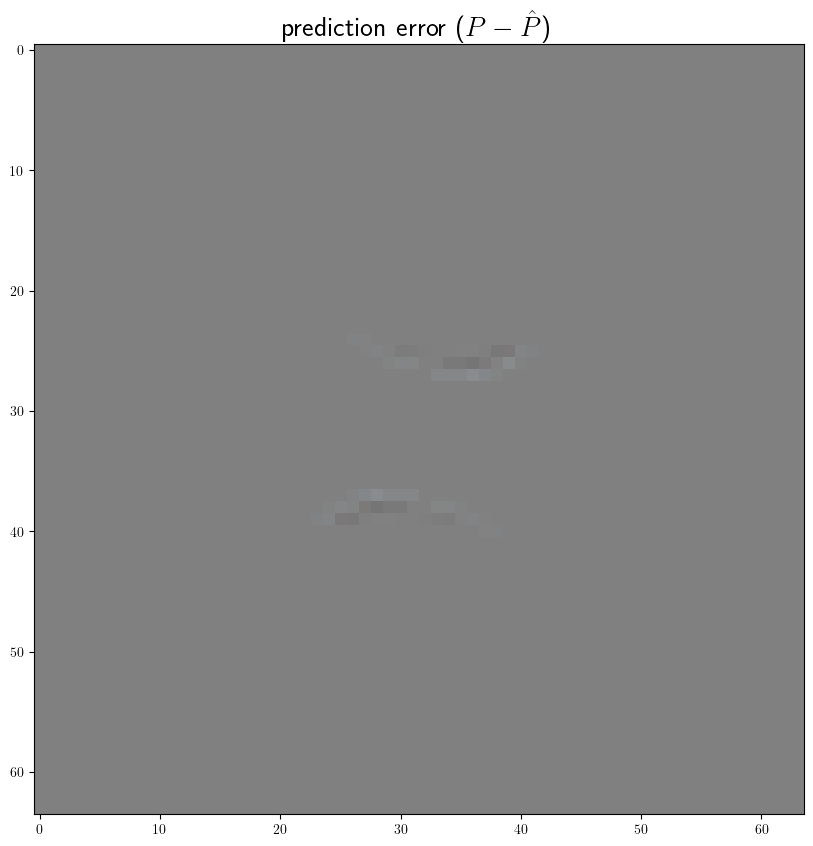

In [32]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [33]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/004.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=720 max=255 min=0
[image_3.py:39 read() INFO] /tmp/004.png (64, 64, 3) uint8 len=720 max=255 min=0


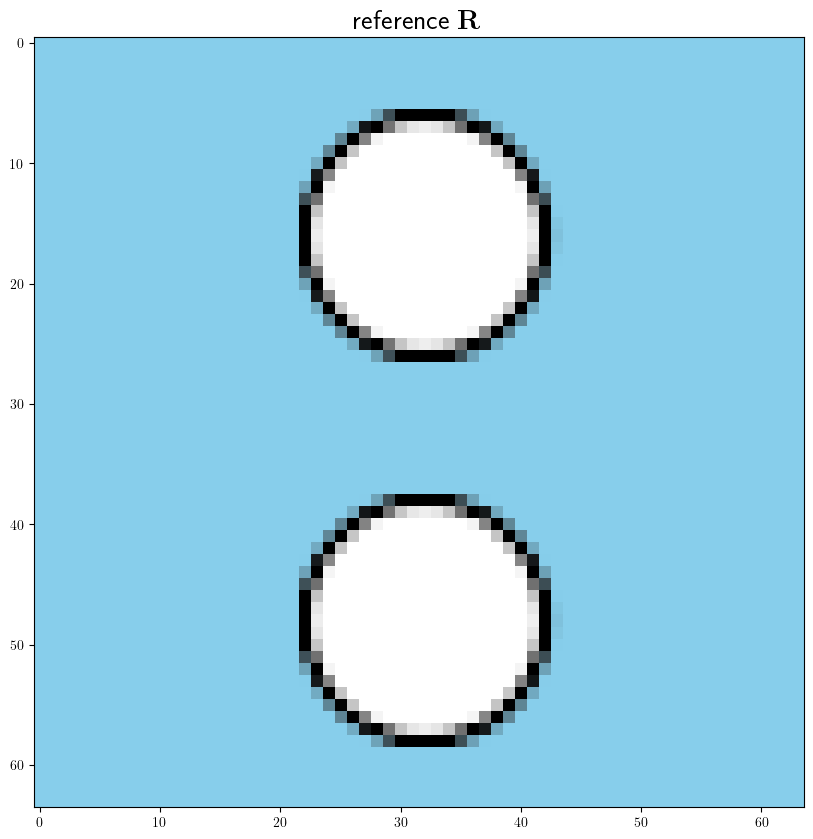

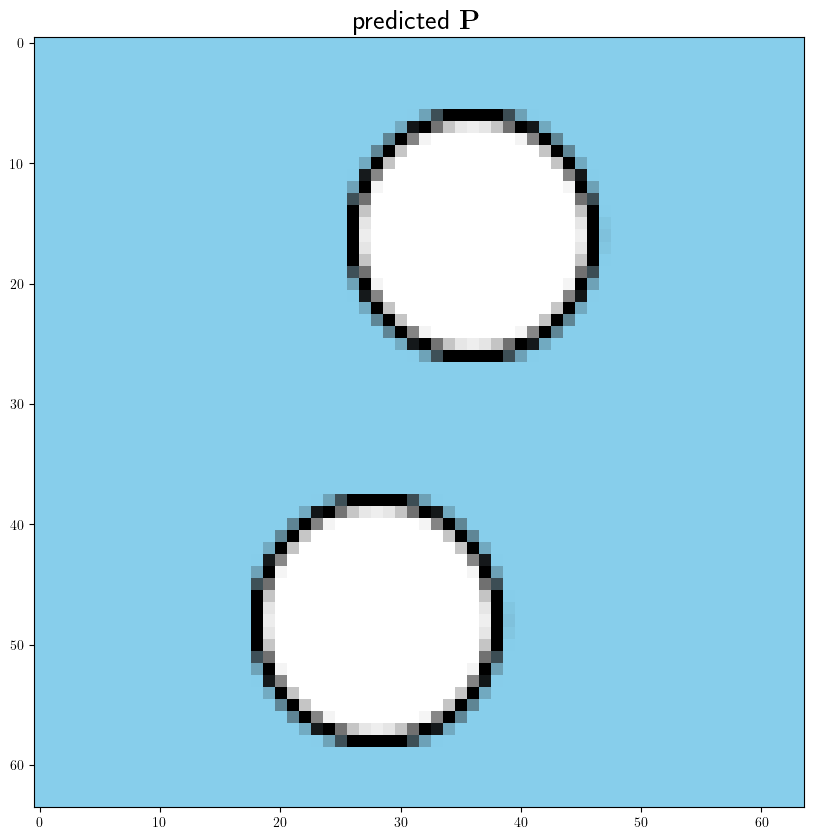

In [34]:
gray_image.show(R, "reference ${\mathbf R}$")
gray_image.show(P, "predicted ${\mathbf P}$")

In [35]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

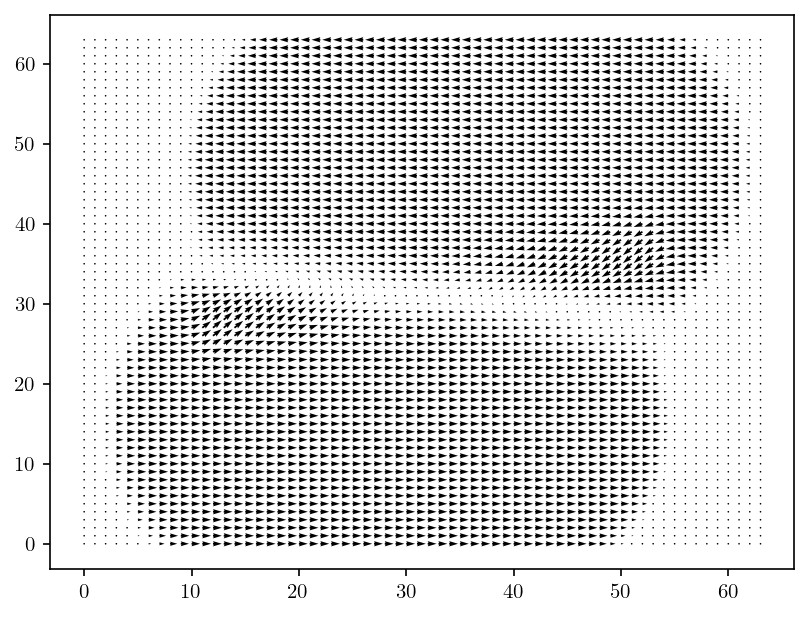

In [36]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.7734375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.472412109375
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.44384765625
[image_3.py:87 print_stats() INFO] component=0 max=141 min=111 avg=128.00390625
[image_3.py:87 print_stats() INFO] component=1 max=147 min=109 avg=128.027099609375
[image_3.py:87 print_stats() INFO] component=2 max=150 min=109 avg=128.03955078125


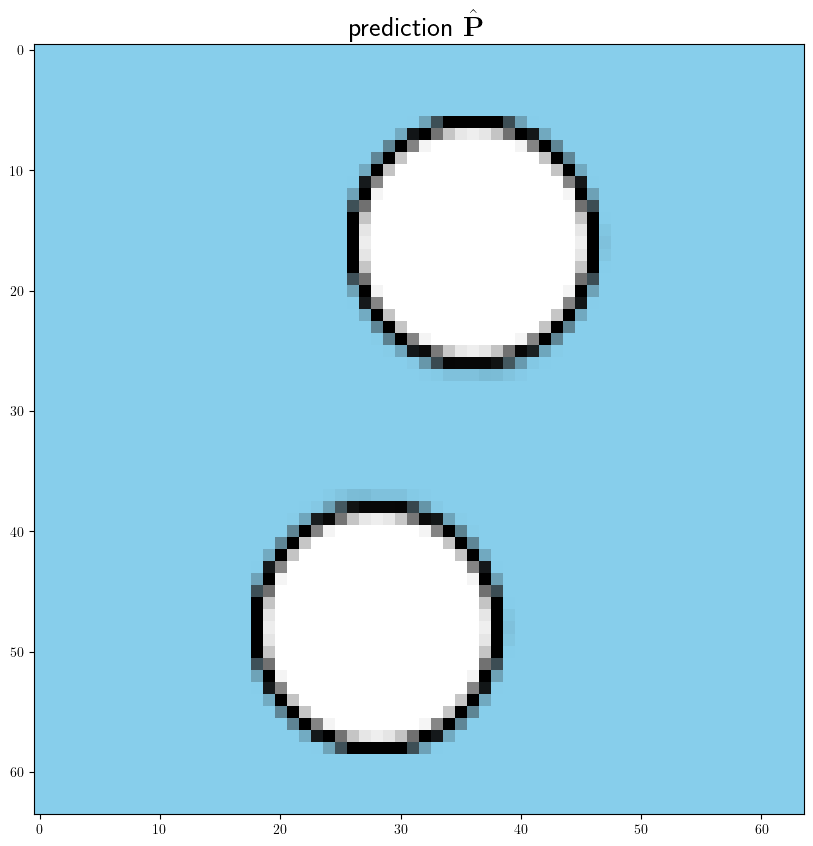

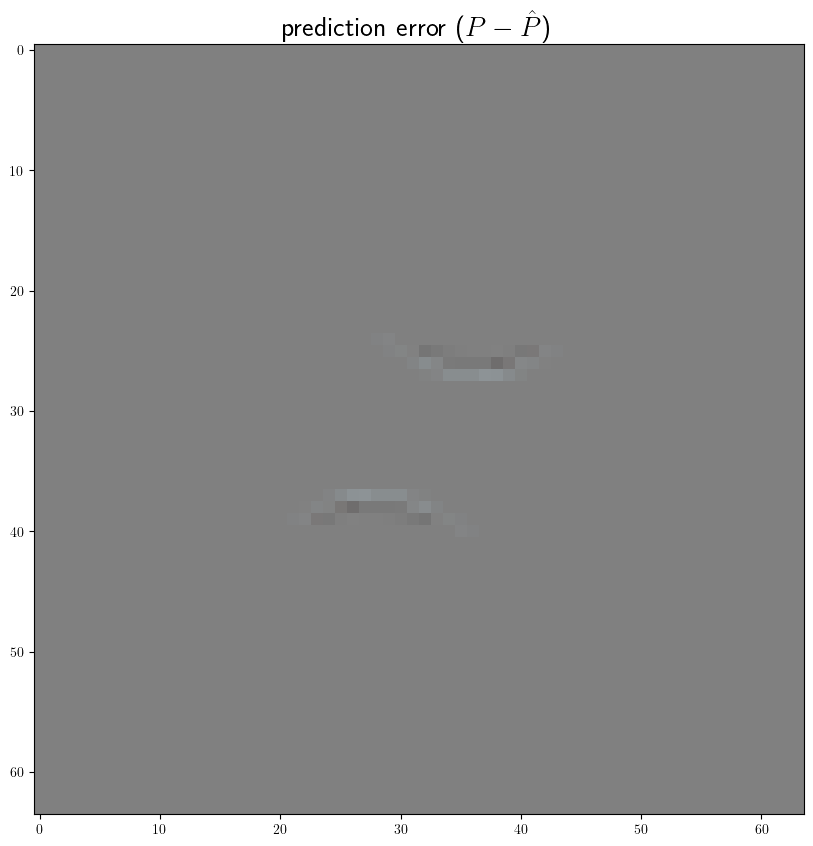

In [37]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

### Conclusion
Farnebäck's ME does not always minimizes the L$_2$ distance.

## Tile of Stockholm

In [38]:
%%bash
URL="https://hpca.ual.es/~vruiz/videos/"
sequence="stockholm_1280x768x50x420x578.avi"
output_prefix="/tmp/original_"
number_of_frames=16
first_frame=2
~/repos/image_synthesis/extract_frames.sh -u $URL -s $sequence -o $output_prefix -n $number_of_frames -f $first_frame

URL = https://hpca.ual.es/~vruiz/videos/
sequence file name = stockholm_1280x768x50x420x578.avi
output prefix = /tmp/original_
number of frames to extract = 16
first frame to extract = 2


--2023-01-27 11:30:24--  https://hpca.ual.es/~vruiz/videos//stockholm_1280x768x50x420x578.avi
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo hpca.ual.es (hpca.ual.es)... 150.214.150.42
Conectando con hpca.ual.es (hpca.ual.es)[150.214.150.42]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 357255516 (341M) [video/x-msvideo]
Grabando a: «/tmp/stockholm_1280x768x50x420x578.avi»

     0K .......... .......... .......... .......... ..........  0%  560K 10m23s
    50K .......... .......... .......... .......... ..........  0% 1,63M 6m56s
   100K .......... .......... .......... .......... ..........  0% 49,4M 4m40s
   150K .......... .......... .......... .......... ..........  0%  101M 3m31s
   200K .......... .......... .......... .......... ..........  0% 1,65M 3m30s
   250K .......... .......... .......... .......... ..........  0% 61,9M 2m56s
   300K .......... .......... .......... .......... ..........  0% 44,3M 2m32s
   350K .

  5050K .......... .......... .......... .......... ..........  1% 90,8M 67s
  5100K .......... .......... .......... .......... ..........  1% 84,3M 67s
  5150K .......... .......... .......... .......... ..........  1% 77,5M 66s
  5200K .......... .......... .......... .......... ..........  1% 81,9M 66s
  5250K .......... .......... .......... .......... ..........  1%  132M 65s
  5300K .......... .......... .......... .......... ..........  1% 2,37M 66s
  5350K .......... .......... .......... .......... ..........  1% 6,35M 66s
  5400K .......... .......... .......... .......... ..........  1% 12,4M 65s
  5450K .......... .......... .......... .......... ..........  1% 34,1M 65s
  5500K .......... .......... .......... .......... ..........  1% 62,6M 64s
  5550K .......... .......... .......... .......... ..........  1% 2,83M 65s
  5600K .......... .......... .......... .......... ..........  1% 1,17M 67s
  5650K .......... .......... .......... .......... ..........  1% 11,4M 66s

 10400K .......... .......... .......... .......... ..........  2% 8,52M 64s
 10450K .......... .......... .......... .......... ..........  3% 7,53M 64s
 10500K .......... .......... .......... .......... ..........  3% 3,16M 64s
 10550K .......... .......... .......... .......... ..........  3% 5,67M 64s
 10600K .......... .......... .......... .......... ..........  3% 1,62M 65s
 10650K .......... .......... .......... .......... ..........  3% 10,7M 64s
 10700K .......... .......... .......... .......... ..........  3% 7,16M 64s
 10750K .......... .......... .......... .......... ..........  3% 5,73M 64s
 10800K .......... .......... .......... .......... ..........  3% 3,92M 64s
 10850K .......... .......... .......... .......... ..........  3% 6,84M 64s
 10900K .......... .......... .......... .......... ..........  3% 52,3M 64s
 10950K .......... .......... .......... .......... ..........  3% 43,4M 64s
 11000K .......... .......... .......... .......... ..........  3% 1,78M 64s

 15750K .......... .......... .......... .......... ..........  4% 76,9M 66s
 15800K .......... .......... .......... .......... ..........  4% 53,0M 66s
 15850K .......... .......... .......... .......... ..........  4%  766K 67s
 15900K .......... .......... .......... .......... ..........  4% 22,4M 67s
 15950K .......... .......... .......... .......... ..........  4% 76,4M 66s
 16000K .......... .......... .......... .......... ..........  4% 28,4M 66s
 16050K .......... .......... .......... .......... ..........  4% 1,53M 67s
 16100K .......... .......... .......... .......... ..........  4% 7,19M 67s
 16150K .......... .......... .......... .......... ..........  4% 48,7M 66s
 16200K .......... .......... .......... .......... ..........  4% 21,7M 66s
 16250K .......... .......... .......... .......... ..........  4% 1,46M 67s
 16300K .......... .......... .......... .......... ..........  4% 12,7M 66s
 16350K .......... .......... .......... .......... ..........  4% 27,7M 66s

 21100K .......... .......... .......... .......... ..........  6% 24,0M 75s
 21150K .......... .......... .......... .......... ..........  6% 1,79M 75s
 21200K .......... .......... .......... .......... ..........  6% 21,1M 75s
 21250K .......... .......... .......... .......... ..........  6% 3,19M 75s
 21300K .......... .......... .......... .......... ..........  6% 3,27M 75s
 21350K .......... .......... .......... .......... ..........  6% 44,9M 75s
 21400K .......... .......... .......... .......... ..........  6% 1,71M 75s
 21450K .......... .......... .......... .......... ..........  6% 26,9M 75s
 21500K .......... .......... .......... .......... ..........  6% 3,44M 75s
 21550K .......... .......... .......... .......... ..........  6% 3,06M 75s
 21600K .......... .......... .......... .......... ..........  6% 51,9M 75s
 21650K .......... .......... .......... .......... ..........  6% 1,70M 75s
 21700K .......... .......... .......... .......... ..........  6% 50,4M 75s

 26450K .......... .......... .......... .......... ..........  7% 14,6M 74s
 26500K .......... .......... .......... .......... ..........  7% 1,95M 74s
 26550K .......... .......... .......... .......... ..........  7% 36,1M 74s
 26600K .......... .......... .......... .......... ..........  7% 17,9M 73s
 26650K .......... .......... .......... .......... ..........  7% 1,86M 74s
 26700K .......... .......... .......... .......... ..........  7% 24,4M 74s
 26750K .......... .......... .......... .......... ..........  7% 29,7M 73s
 26800K .......... .......... .......... .......... ..........  7% 1,90M 74s
 26850K .......... .......... .......... .......... ..........  7% 7,09M 73s
 26900K .......... .......... .......... .......... ..........  7% 32,6M 73s
 26950K .......... .......... .......... .......... ..........  7% 2,37M 73s
 27000K .......... .......... .......... .......... ..........  7% 5,78M 73s
 27050K .......... .......... .......... .......... ..........  7% 41,5M 73s

 31800K .......... .......... .......... .......... ..........  9% 3,98M 70s
 31850K .......... .......... .......... .......... ..........  9% 5,66M 70s
 31900K .......... .......... .......... .......... ..........  9% 5,05M 70s
 31950K .......... .......... .......... .......... ..........  9% 15,3M 70s
 32000K .......... .......... .......... .......... ..........  9% 2,93M 70s
 32050K .......... .......... .......... .......... ..........  9% 5,42M 70s
 32100K .......... .......... .......... .......... ..........  9% 34,0M 70s
 32150K .......... .......... .......... .......... ..........  9% 4,71M 70s
 32200K .......... .......... .......... .......... ..........  9% 5,38M 70s
 32250K .......... .......... .......... .......... ..........  9% 4,49M 70s
 32300K .......... .......... .......... .......... ..........  9% 48,7M 70s
 32350K .......... .......... .......... .......... ..........  9% 5,05M 70s
 32400K .......... .......... .......... .......... ..........  9% 2,67M 70s

 37150K .......... .......... .......... .......... .......... 10% 5,99M 67s
 37200K .......... .......... .......... .......... .......... 10% 45,3M 66s
 37250K .......... .......... .......... .......... .......... 10% 8,19M 66s
 37300K .......... .......... .......... .......... .......... 10% 3,38M 66s
 37350K .......... .......... .......... .......... .......... 10% 5,60M 66s
 37400K .......... .......... .......... .......... .......... 10% 16,5M 66s
 37450K .......... .......... .......... .......... .......... 10% 11,3M 66s
 37500K .......... .......... .......... .......... .......... 10% 3,67M 66s
 37550K .......... .......... .......... .......... .......... 10% 4,49M 66s
 37600K .......... .......... .......... .......... .......... 10% 26,9M 66s
 37650K .......... .......... .......... .......... .......... 10% 9,36M 66s
 37700K .......... .......... .......... .......... .......... 10% 4,02M 66s
 37750K .......... .......... .......... .......... .......... 10% 4,23M 66s

 42500K .......... .......... .......... .......... .......... 12% 4,53M 63s
 42550K .......... .......... .......... .......... .......... 12% 3,49M 63s
 42600K .......... .......... .......... .......... .......... 12% 36,8M 63s
 42650K .......... .......... .......... .......... .......... 12% 23,6M 63s
 42700K .......... .......... .......... .......... .......... 12% 8,94M 63s
 42750K .......... .......... .......... .......... .......... 12% 2,29M 63s
 42800K .......... .......... .......... .......... .......... 12% 28,3M 63s
 42850K .......... .......... .......... .......... .......... 12% 66,8M 63s
 42900K .......... .......... .......... .......... .......... 12% 9,38M 63s
 42950K .......... .......... .......... .......... .......... 12% 2,11M 63s
 43000K .......... .......... .......... .......... .......... 12% 51,5M 63s
 43050K .......... .......... .......... .......... .......... 12% 30,7M 63s
 43100K .......... .......... .......... .......... .......... 12% 17,1M 63s

 47850K .......... .......... .......... .......... .......... 13% 76,1M 63s
 47900K .......... .......... .......... .......... .......... 13% 1,67M 63s
 47950K .......... .......... .......... .......... .......... 13% 53,9M 63s
 48000K .......... .......... .......... .......... .......... 13% 39,3M 63s
 48050K .......... .......... .......... .......... .......... 13% 11,8M 63s
 48100K .......... .......... .......... .......... .......... 13% 1,91M 63s
 48150K .......... .......... .......... .......... .......... 13% 47,1M 63s
 48200K .......... .......... .......... .......... .......... 13% 18,1M 63s
 48250K .......... .......... .......... .......... .......... 13%  116M 62s
 48300K .......... .......... .......... .......... .......... 13% 1,59M 63s
 48350K .......... .......... .......... .......... .......... 13% 46,8M 62s
 48400K .......... .......... .......... .......... .......... 13% 33,4M 62s
 48450K .......... .......... .......... .......... .......... 13% 1,62M 63s

 53200K .......... .......... .......... .......... .......... 15% 2,11M 60s
 53250K .......... .......... .......... .......... .......... 15% 15,8M 60s
 53300K .......... .......... .......... .......... .......... 15% 23,3M 60s
 53350K .......... .......... .......... .......... .......... 15% 30,1M 60s
 53400K .......... .......... .......... .......... .......... 15% 3,46M 60s
 53450K .......... .......... .......... .......... .......... 15% 5,46M 60s
 53500K .......... .......... .......... .......... .......... 15% 8,02M 60s
 53550K .......... .......... .......... .......... .......... 15% 22,8M 60s
 53600K .......... .......... .......... .......... .......... 15% 3,53M 60s
 53650K .......... .......... .......... .......... .......... 15% 6,52M 60s
 53700K .......... .......... .......... .......... .......... 15% 8,92M 60s
 53750K .......... .......... .......... .......... .......... 15% 32,2M 60s
 53800K .......... .......... .......... .......... .......... 15% 3,37M 60s

 58550K .......... .......... .......... .......... .......... 16% 5,38M 58s
 58600K .......... .......... .......... .......... .......... 16% 3,04M 58s
 58650K .......... .......... .......... .......... .......... 16% 52,1M 58s
 58700K .......... .......... .......... .......... .......... 16% 14,1M 58s
 58750K .......... .......... .......... .......... .......... 16% 12,9M 58s
 58800K .......... .......... .......... .......... .......... 16% 2,33M 58s
 58850K .......... .......... .......... .......... .......... 16% 21,1M 58s
 58900K .......... .......... .......... .......... .......... 16% 17,8M 57s
 58950K .......... .......... .......... .......... .......... 16% 43,0M 57s
 59000K .......... .......... .......... .......... .......... 16% 5,43M 57s
 59050K .......... .......... .......... .......... .......... 16% 3,18M 57s
 59100K .......... .......... .......... .......... .......... 16% 8,54M 57s
 59150K .......... .......... .......... .......... .......... 16% 25,0M 57s

 63900K .......... .......... .......... .......... .......... 18% 2,15M 55s
 63950K .......... .......... .......... .......... .......... 18% 28,3M 55s
 64000K .......... .......... .......... .......... .......... 18% 20,7M 55s
 64050K .......... .......... .......... .......... .......... 18% 16,7M 55s
 64100K .......... .......... .......... .......... .......... 18% 40,5M 55s
 64150K .......... .......... .......... .......... .......... 18% 2,00M 55s
 64200K .......... .......... .......... .......... .......... 18% 31,6M 55s
 64250K .......... .......... .......... .......... .......... 18% 11,6M 55s
 64300K .......... .......... .......... .......... .......... 18% 52,5M 55s
 64350K .......... .......... .......... .......... .......... 18% 2,38M 55s
 64400K .......... .......... .......... .......... .......... 18% 11,2M 55s
 64450K .......... .......... .......... .......... .......... 18% 33,4M 55s
 64500K .......... .......... .......... .......... .......... 18% 14,3M 55s

 69250K .......... .......... .......... .......... .......... 19% 38,3M 53s
 69300K .......... .......... .......... .......... .......... 19% 11,1M 53s
 69350K .......... .......... .......... .......... .......... 19% 3,20M 53s
 69400K .......... .......... .......... .......... .......... 19% 9,56M 53s
 69450K .......... .......... .......... .......... .......... 19% 9,89M 53s
 69500K .......... .......... .......... .......... .......... 19% 46,1M 53s
 69550K .......... .......... .......... .......... .......... 19% 4,30M 53s
 69600K .......... .......... .......... .......... .......... 19% 4,88M 53s
 69650K .......... .......... .......... .......... .......... 19% 6,82M 53s
 69700K .......... .......... .......... .......... .......... 19% 43,6M 53s
 69750K .......... .......... .......... .......... .......... 20% 17,8M 53s
 69800K .......... .......... .......... .......... .......... 20% 2,74M 53s
 69850K .......... .......... .......... .......... .......... 20% 45,1M 53s

 74600K .......... .......... .......... .......... .......... 21% 7,54M 51s
 74650K .......... .......... .......... .......... .......... 21% 27,2M 51s
 74700K .......... .......... .......... .......... .......... 21% 3,18M 51s
 74750K .......... .......... .......... .......... .......... 21% 22,3M 51s
 74800K .......... .......... .......... .......... .......... 21% 31,5M 51s
 74850K .......... .......... .......... .......... .......... 21% 5,83M 51s
 74900K .......... .......... .......... .......... .......... 21% 11,0M 51s
 74950K .......... .......... .......... .......... .......... 21% 2,94M 51s
 75000K .......... .......... .......... .......... .......... 21% 48,5M 50s
 75050K .......... .......... .......... .......... .......... 21% 46,9M 50s
 75100K .......... .......... .......... .......... .......... 21% 12,4M 50s
 75150K .......... .......... .......... .......... .......... 21% 6,33M 50s
 75200K .......... .......... .......... .......... .......... 21% 2,99M 50s

 79950K .......... .......... .......... .......... .......... 22% 93,2M 48s
 80000K .......... .......... .......... .......... .......... 22%  401K 49s
 80050K .......... .......... .......... .......... .......... 22% 1,93M 49s
 80100K .......... .......... .......... .......... .......... 22% 59,7M 49s
 80150K .......... .......... .......... .......... .......... 22% 8,72M 49s
 80200K .......... .......... .......... .......... .......... 23% 2,13M 49s
 80250K .......... .......... .......... .......... .......... 23% 18,2M 49s
 80300K .......... .......... .......... .......... .......... 23% 12,6M 49s
 80350K .......... .......... .......... .......... .......... 23% 1,75M 49s
 80400K .......... .......... .......... .......... .......... 23% 36,1M 49s
 80450K .......... .......... .......... .......... .......... 23% 69,3M 49s
 80500K .......... .......... .......... .......... .......... 23% 1,70M 49s
 80550K .......... .......... .......... .......... .......... 23% 6,20M 49s

 85300K .......... .......... .......... .......... .......... 24% 10,2M 49s
 85350K .......... .......... .......... .......... .......... 24% 1,99M 49s
 85400K .......... .......... .......... .......... .......... 24% 37,7M 49s
 85450K .......... .......... .......... .......... .......... 24% 53,4M 49s
 85500K .......... .......... .......... .......... .......... 24% 4,20M 49s
 85550K .......... .......... .......... .......... .......... 24% 2,72M 49s
 85600K .......... .......... .......... .......... .......... 24% 27,1M 49s
 85650K .......... .......... .......... .......... .......... 24% 5,16M 49s
 85700K .......... .......... .......... .......... .......... 24% 2,53M 49s
 85750K .......... .......... .......... .......... .......... 24% 26,9M 49s
 85800K .......... .......... .......... .......... .......... 24% 9,08M 49s
 85850K .......... .......... .......... .......... .......... 24% 1,99M 49s
 85900K .......... .......... .......... .......... .......... 24% 45,4M 49s

 90650K .......... .......... .......... .......... .......... 25% 2,39M 48s
 90700K .......... .......... .......... .......... .......... 26% 13,0M 48s
 90750K .......... .......... .......... .......... .......... 26% 8,31M 48s
 90800K .......... .......... .......... .......... .......... 26% 33,4M 48s
 90850K .......... .......... .......... .......... .......... 26% 2,30M 48s
 90900K .......... .......... .......... .......... .......... 26% 42,1M 48s
 90950K .......... .......... .......... .......... .......... 26% 6,32M 48s
 91000K .......... .......... .......... .......... .......... 26% 50,0M 48s
 91050K .......... .......... .......... .......... .......... 26% 2,42M 48s
 91100K .......... .......... .......... .......... .......... 26% 78,3M 48s
 91150K .......... .......... .......... .......... .......... 26% 5,76M 47s
 91200K .......... .......... .......... .......... .......... 26% 3,00M 48s
 91250K .......... .......... .......... .......... .......... 26% 10,8M 47s

 96000K .......... .......... .......... .......... .......... 27% 7,01M 46s
 96050K .......... .......... .......... .......... .......... 27% 22,4M 46s
 96100K .......... .......... .......... .......... .......... 27% 16,1M 46s
 96150K .......... .......... .......... .......... .......... 27% 2,80M 46s
 96200K .......... .......... .......... .......... .......... 27% 5,40M 46s
 96250K .......... .......... .......... .......... .......... 27% 86,9M 46s
 96300K .......... .......... .......... .......... .......... 27% 17,0M 46s
 96350K .......... .......... .......... .......... .......... 27% 2,89M 46s
 96400K .......... .......... .......... .......... .......... 27% 5,77M 46s
 96450K .......... .......... .......... .......... .......... 27% 10,6M 46s
 96500K .......... .......... .......... .......... .......... 27% 40,5M 46s
 96550K .......... .......... .......... .......... .......... 27% 3,09M 46s
 96600K .......... .......... .......... .......... .......... 27% 5,77M 46s

101350K .......... .......... .......... .......... .......... 29% 4,61M 45s
101400K .......... .......... .......... .......... .......... 29% 69,6M 45s
101450K .......... .......... .......... .......... .......... 29% 4,70M 45s
101500K .......... .......... .......... .......... .......... 29% 5,33M 45s
101550K .......... .......... .......... .......... .......... 29% 11,8M 45s
101600K .......... .......... .......... .......... .......... 29% 5,58M 45s
101650K .......... .......... .......... .......... .......... 29% 14,1M 45s
101700K .......... .......... .......... .......... .......... 29% 3,59M 45s
101750K .......... .......... .......... .......... .......... 29% 8,74M 45s
101800K .......... .......... .......... .......... .......... 29% 4,67M 45s
101850K .......... .......... .......... .......... .......... 29% 24,9M 45s
101900K .......... .......... .......... .......... .......... 29% 5,38M 45s
101950K .......... .......... .......... .......... .......... 29% 11,9M 45s

106700K .......... .......... .......... .......... .......... 30% 16,7M 43s
106750K .......... .......... .......... .......... .......... 30% 19,9M 43s
106800K .......... .......... .......... .......... .......... 30% 3,70M 43s
106850K .......... .......... .......... .......... .......... 30% 7,13M 43s
106900K .......... .......... .......... .......... .......... 30% 5,59M 43s
106950K .......... .......... .......... .......... .......... 30% 36,4M 43s
107000K .......... .......... .......... .......... .......... 30% 75,2M 43s
107050K .......... .......... .......... .......... .......... 30% 4,12M 43s
107100K .......... .......... .......... .......... .......... 30% 7,77M 43s
107150K .......... .......... .......... .......... .......... 30% 4,10M 43s
107200K .......... .......... .......... .......... .......... 30% 46,9M 43s
107250K .......... .......... .......... .......... .......... 30% 4,88M 43s
107300K .......... .......... .......... .......... .......... 30% 7,55M 43s

112050K .......... .......... .......... .......... .......... 32% 12,3M 42s
112100K .......... .......... .......... .......... .......... 32% 1,89M 42s
112150K .......... .......... .......... .......... .......... 32% 79,3M 42s
112200K .......... .......... .......... .......... .......... 32% 49,3M 42s
112250K .......... .......... .......... .......... .......... 32% 40,6M 42s
112300K .......... .......... .......... .......... .......... 32% 89,4M 42s
112350K .......... .......... .......... .......... .......... 32% 5,38M 42s
112400K .......... .......... .......... .......... .......... 32% 2,49M 42s
112450K .......... .......... .......... .......... .......... 32% 51,0M 42s
112500K .......... .......... .......... .......... .......... 32% 44,0M 42s
112550K .......... .......... .......... .......... .......... 32% 83,9M 42s
112600K .......... .......... .......... .......... .......... 32% 5,52M 42s
112650K .......... .......... .......... .......... .......... 32% 2,45M 42s

117400K .......... .......... .......... .......... .......... 33% 4,35M 40s
117450K .......... .......... .......... .......... .......... 33% 4,57M 40s
117500K .......... .......... .......... .......... .......... 33% 6,29M 40s
117550K .......... .......... .......... .......... .......... 33% 45,1M 40s
117600K .......... .......... .......... .......... .......... 33% 53,9M 40s
117650K .......... .......... .......... .......... .......... 33% 10,2M 40s
117700K .......... .......... .......... .......... .......... 33% 3,31M 40s
117750K .......... .......... .......... .......... .......... 33% 5,27M 40s
117800K .......... .......... .......... .......... .......... 33% 63,6M 40s
117850K .......... .......... .......... .......... .......... 33% 16,3M 40s
117900K .......... .......... .......... .......... .......... 33% 47,4M 40s
117950K .......... .......... .......... .......... .......... 33% 7,03M 40s
118000K .......... .......... .......... .......... .......... 33% 2,73M 40s

122750K .......... .......... .......... .......... .......... 35% 5,09M 39s
122800K .......... .......... .......... .......... .......... 35% 4,11M 39s
122850K .......... .......... .......... .......... .......... 35% 6,79M 39s
122900K .......... .......... .......... .......... .......... 35% 15,7M 39s
122950K .......... .......... .......... .......... .......... 35% 49,4M 39s
123000K .......... .......... .......... .......... .......... 35% 11,3M 39s
123050K .......... .......... .......... .......... .......... 35% 21,1M 39s
123100K .......... .......... .......... .......... .......... 35% 4,23M 39s
123150K .......... .......... .......... .......... .......... 35% 6,68M 39s
123200K .......... .......... .......... .......... .......... 35% 12,7M 39s
123250K .......... .......... .......... .......... .......... 35% 39,0M 39s
123300K .......... .......... .......... .......... .......... 35% 9,80M 39s
123350K .......... .......... .......... .......... .......... 35% 4,26M 39s

128100K .......... .......... .......... .......... .......... 36% 12,0M 37s
128150K .......... .......... .......... .......... .......... 36% 2,06M 37s
128200K .......... .......... .......... .......... .......... 36% 69,6M 37s
128250K .......... .......... .......... .......... .......... 36% 38,5M 37s
128300K .......... .......... .......... .......... .......... 36% 53,1M 37s
128350K .......... .......... .......... .......... .......... 36% 64,3M 37s
128400K .......... .......... .......... .......... .......... 36% 18,9M 37s
128450K .......... .......... .......... .......... .......... 36% 1,75M 37s
128500K .......... .......... .......... .......... .......... 36% 47,5M 37s
128550K .......... .......... .......... .......... .......... 36% 58,7M 37s
128600K .......... .......... .......... .......... .......... 36% 51,5M 37s
128650K .......... .......... .......... .......... .......... 36% 58,7M 37s
128700K .......... .......... .......... .......... .......... 36% 42,9M 37s

133450K .......... .......... .......... .......... .......... 38% 8,27M 36s
133500K .......... .......... .......... .......... .......... 38% 21,4M 36s
133550K .......... .......... .......... .......... .......... 38%  118M 36s
133600K .......... .......... .......... .......... .......... 38% 81,8M 36s
133650K .......... .......... .......... .......... .......... 38% 3,42M 36s
133700K .......... .......... .......... .......... .......... 38% 9,83M 36s
133750K .......... .......... .......... .......... .......... 38% 5,15M 36s
133800K .......... .......... .......... .......... .......... 38% 67,0M 36s
133850K .......... .......... .......... .......... .......... 38% 55,4M 36s
133900K .......... .......... .......... .......... .......... 38% 57,1M 36s
133950K .......... .......... .......... .......... .......... 38% 59,2M 36s
134000K .......... .......... .......... .......... .......... 38% 2,87M 36s
134050K .......... .......... .......... .......... .......... 38% 4,18M 36s

138800K .......... .......... .......... .......... .......... 39% 3,84M 34s
138850K .......... .......... .......... .......... .......... 39% 2,65M 34s
138900K .......... .......... .......... .......... .......... 39% 6,92M 34s
138950K .......... .......... .......... .......... .......... 39% 33,3M 34s
139000K .......... .......... .......... .......... .......... 39% 26,9M 34s
139050K .......... .......... .......... .......... .......... 39% 27,5M 34s
139100K .......... .......... .......... .......... .......... 39% 91,7M 34s
139150K .......... .......... .......... .......... .......... 39% 26,3M 34s
139200K .......... .......... .......... .......... .......... 39% 1,71M 34s
139250K .......... .......... .......... .......... .......... 39% 18,1M 34s
139300K .......... .......... .......... .......... .......... 39% 88,1M 34s
139350K .......... .......... .......... .......... .......... 39% 48,9M 34s
139400K .......... .......... .......... .......... .......... 39% 68,7M 34s

144150K .......... .......... .......... .......... .......... 41%  145M 33s
144200K .......... .......... .......... .......... .......... 41% 1,81M 33s
144250K .......... .......... .......... .......... .......... 41% 90,3M 33s
144300K .......... .......... .......... .......... .......... 41% 35,3M 33s
144350K .......... .......... .......... .......... .......... 41% 45,3M 33s
144400K .......... .......... .......... .......... .......... 41% 85,8M 33s
144450K .......... .......... .......... .......... .......... 41% 37,2M 33s
144500K .......... .......... .......... .......... .......... 41% 8,03M 33s
144550K .......... .......... .......... .......... .......... 41% 2,27M 33s
144600K .......... .......... .......... .......... .......... 41% 68,1M 33s
144650K .......... .......... .......... .......... .......... 41% 46,9M 33s
144700K .......... .......... .......... .......... .......... 41% 44,0M 33s
144750K .......... .......... .......... .......... .......... 41% 34,2M 33s

149500K .......... .......... .......... .......... .......... 42% 45,6M 32s
149550K .......... .......... .......... .......... .......... 42% 61,8M 32s
149600K .......... .......... .......... .......... .......... 42% 34,7M 32s
149650K .......... .......... .......... .......... .......... 42% 16,5M 32s
149700K .......... .......... .......... .......... .......... 42% 25,4M 32s
149750K .......... .......... .......... .......... .......... 42% 2,09M 32s
149800K .......... .......... .......... .......... .......... 42% 76,9M 32s
149850K .......... .......... .......... .......... .......... 42% 39,9M 32s
149900K .......... .......... .......... .......... .......... 42% 63,7M 32s
149950K .......... .......... .......... .......... .......... 42% 35,9M 32s
150000K .......... .......... .......... .......... .......... 43% 19,6M 32s
150050K .......... .......... .......... .......... .......... 43% 21,7M 32s
150100K .......... .......... .......... .......... .......... 43% 2,12M 32s

154850K .......... .......... .......... .......... .......... 44% 49,0M 31s
154900K .......... .......... .......... .......... .......... 44% 32,4M 30s
154950K .......... .......... .......... .......... .......... 44% 39,4M 30s
155000K .......... .......... .......... .......... .......... 44% 53,1M 30s
155050K .......... .......... .......... .......... .......... 44% 23,4M 30s
155100K .......... .......... .......... .......... .......... 44% 4,33M 30s
155150K .......... .......... .......... .......... .......... 44% 3,16M 30s
155200K .......... .......... .......... .......... .......... 44% 35,5M 30s
155250K .......... .......... .......... .......... .......... 44% 65,2M 30s
155300K .......... .......... .......... .......... .......... 44% 39,3M 30s
155350K .......... .......... .......... .......... .......... 44% 57,8M 30s
155400K .......... .......... .......... .......... .......... 44% 45,2M 30s
155450K .......... .......... .......... .......... .......... 44% 5,66M 30s

160200K .......... .......... .......... .......... .......... 45% 74,7M 29s
160250K .......... .......... .......... .......... .......... 45% 42,6M 29s
160300K .......... .......... .......... .......... .......... 45% 1,93M 29s
160350K .......... .......... .......... .......... .......... 45% 19,5M 29s
160400K .......... .......... .......... .......... .......... 45% 32,1M 29s
160450K .......... .......... .......... .......... .......... 46% 44,8M 29s
160500K .......... .......... .......... .......... .......... 46% 52,6M 29s
160550K .......... .......... .......... .......... .......... 46% 39,9M 29s
160600K .......... .......... .......... .......... .......... 46% 69,7M 29s
160650K .......... .......... .......... .......... .......... 46% 2,31M 29s
160700K .......... .......... .......... .......... .......... 46% 8,51M 29s
160750K .......... .......... .......... .......... .......... 46% 15,9M 29s
160800K .......... .......... .......... .......... .......... 46% 42,3M 29s

165550K .......... .......... .......... .......... .......... 47% 59,0M 28s
165600K .......... .......... .......... .......... .......... 47% 1,71M 28s
165650K .......... .......... .......... .......... .......... 47% 67,7M 28s
165700K .......... .......... .......... .......... .......... 47% 39,5M 28s
165750K .......... .......... .......... .......... .......... 47% 70,6M 28s
165800K .......... .......... .......... .......... .......... 47% 53,6M 28s
165850K .......... .......... .......... .......... .......... 47% 39,7M 28s
165900K .......... .......... .......... .......... .......... 47% 90,5M 28s
165950K .......... .......... .......... .......... .......... 47% 9,51M 28s
166000K .......... .......... .......... .......... .......... 47% 2,20M 28s
166050K .......... .......... .......... .......... .......... 47% 19,5M 28s
166100K .......... .......... .......... .......... .......... 47% 48,9M 28s
166150K .......... .......... .......... .......... .......... 47% 32,8M 28s

170900K .......... .......... .......... .......... .......... 48% 72,7M 27s
170950K .......... .......... .......... .......... .......... 49% 46,3M 27s
171000K .......... .......... .......... .......... .......... 49% 48,7M 27s
171050K .......... .......... .......... .......... .......... 49% 17,4M 27s
171100K .......... .......... .......... .......... .......... 49% 1,92M 27s
171150K .......... .......... .......... .......... .......... 49% 50,4M 27s
171200K .......... .......... .......... .......... .......... 49% 34,3M 27s
171250K .......... .......... .......... .......... .......... 49% 66,2M 27s
171300K .......... .......... .......... .......... .......... 49% 63,5M 27s
171350K .......... .......... .......... .......... .......... 49% 33,9M 27s
171400K .......... .......... .......... .......... .......... 49% 53,4M 27s
171450K .......... .......... .......... .......... .......... 49%  115M 27s
171500K .......... .......... .......... .......... .......... 49% 1,86M 27s

176250K .......... .......... .......... .......... .......... 50% 33,2M 26s
176300K .......... .......... .......... .......... .......... 50%  102M 26s
176350K .......... .......... .......... .......... .......... 50% 3,05M 26s
176400K .......... .......... .......... .......... .......... 50% 3,43M 26s
176450K .......... .......... .......... .......... .......... 50% 57,1M 26s
176500K .......... .......... .......... .......... .......... 50% 65,4M 26s
176550K .......... .......... .......... .......... .......... 50% 38,8M 26s
176600K .......... .......... .......... .......... .......... 50% 72,4M 26s
176650K .......... .......... .......... .......... .......... 50% 58,6M 26s
176700K .......... .......... .......... .......... .......... 50% 23,8M 26s
176750K .......... .......... .......... .......... .......... 50% 5,87M 26s
176800K .......... .......... .......... .......... .......... 50% 7,70M 26s
176850K .......... .......... .......... .......... .......... 50% 3,93M 26s

181600K .......... .......... .......... .......... .......... 52% 1,75M 25s
181650K .......... .......... .......... .......... .......... 52% 34,6M 25s
181700K .......... .......... .......... .......... .......... 52% 31,1M 25s
181750K .......... .......... .......... .......... .......... 52% 28,4M 25s
181800K .......... .......... .......... .......... .......... 52% 23,3M 25s
181850K .......... .......... .......... .......... .......... 52% 28,5M 25s
181900K .......... .......... .......... .......... .......... 52% 22,3M 25s
181950K .......... .......... .......... .......... .......... 52%  114M 25s
182000K .......... .......... .......... .......... .......... 52% 6,41M 25s
182050K .......... .......... .......... .......... .......... 52% 2,24M 25s
182100K .......... .......... .......... .......... .......... 52% 42,6M 25s
182150K .......... .......... .......... .......... .......... 52% 26,6M 25s
182200K .......... .......... .......... .......... .......... 52% 24,6M 24s

186950K .......... .......... .......... .......... .......... 53% 2,27M 23s
187000K .......... .......... .......... .......... .......... 53% 20,7M 23s
187050K .......... .......... .......... .......... .......... 53% 75,8M 23s
187100K .......... .......... .......... .......... .......... 53% 57,0M 23s
187150K .......... .......... .......... .......... .......... 53% 39,8M 23s
187200K .......... .......... .......... .......... .......... 53% 42,1M 23s
187250K .......... .......... .......... .......... .......... 53% 85,6M 23s
187300K .......... .......... .......... .......... .......... 53% 21,9M 23s
187350K .......... .......... .......... .......... .......... 53% 69,7M 23s
187400K .......... .......... .......... .......... .......... 53% 64,3M 23s
187450K .......... .......... .......... .......... .......... 53% 2,01M 23s
187500K .......... .......... .......... .......... .......... 53% 10,1M 23s
187550K .......... .......... .......... .......... .......... 53% 54,5M 23s

192300K .......... .......... .......... .......... .......... 55% 31,7M 22s
192350K .......... .......... .......... .......... .......... 55% 65,5M 22s
192400K .......... .......... .......... .......... .......... 55% 38,6M 22s
192450K .......... .......... .......... .......... .......... 55% 48,4M 22s
192500K .......... .......... .......... .......... .......... 55% 87,5M 22s
192550K .......... .......... .......... .......... .......... 55% 57,9M 22s
192600K .......... .......... .......... .......... .......... 55% 48,3M 22s
192650K .......... .......... .......... .......... .......... 55% 7,10M 22s
192700K .......... .......... .......... .......... .......... 55% 1,25M 22s
192750K .......... .......... .......... .......... .......... 55% 59,6M 22s
192800K .......... .......... .......... .......... .......... 55% 24,5M 22s
192850K .......... .......... .......... .......... .......... 55% 78,9M 22s
192900K .......... .......... .......... .......... .......... 55% 48,3M 22s

197650K .......... .......... .......... .......... .......... 56% 48,9M 21s
197700K .......... .......... .......... .......... .......... 56% 63,6M 21s
197750K .......... .......... .......... .......... .......... 56% 63,1M 21s
197800K .......... .......... .......... .......... .......... 56% 4,17M 21s
197850K .......... .......... .......... .......... .......... 56% 8,21M 21s
197900K .......... .......... .......... .......... .......... 56% 97,8M 21s
197950K .......... .......... .......... .......... .......... 56% 7,89M 21s
198000K .......... .......... .......... .......... .......... 56% 14,1M 21s
198050K .......... .......... .......... .......... .......... 56% 42,1M 21s
198100K .......... .......... .......... .......... .......... 56% 52,6M 21s
198150K .......... .......... .......... .......... .......... 56% 71,9M 21s
198200K .......... .......... .......... .......... .......... 56% 62,6M 21s
198250K .......... .......... .......... .......... .......... 56% 56,9M 21s

203000K .......... .......... .......... .......... .......... 58% 6,20M 20s
203050K .......... .......... .......... .......... .......... 58% 45,1M 20s
203100K .......... .......... .......... .......... .......... 58% 9,13M 20s
203150K .......... .......... .......... .......... .......... 58% 72,3M 20s
203200K .......... .......... .......... .......... .......... 58% 17,9M 20s
203250K .......... .......... .......... .......... .......... 58% 35,4M 20s
203300K .......... .......... .......... .......... .......... 58% 48,8M 20s
203350K .......... .......... .......... .......... .......... 58% 77,4M 20s
203400K .......... .......... .......... .......... .......... 58% 69,2M 20s
203450K .......... .......... .......... .......... .......... 58% 33,1M 20s
203500K .......... .......... .......... .......... .......... 58% 84,9M 20s
203550K .......... .......... .......... .......... .......... 58% 62,8M 20s
203600K .......... .......... .......... .......... .......... 58% 7,97M 20s

208350K .......... .......... .......... .......... .......... 59% 63,9M 19s
208400K .......... .......... .......... .......... .......... 59% 2,47M 19s
208450K .......... .......... .......... .......... .......... 59% 10,3M 19s
208500K .......... .......... .......... .......... .......... 59% 53,4M 19s
208550K .......... .......... .......... .......... .......... 59% 82,2M 19s
208600K .......... .......... .......... .......... .......... 59% 15,9M 19s
208650K .......... .......... .......... .......... .......... 59% 44,2M 19s
208700K .......... .......... .......... .......... .......... 59% 49,7M 19s
208750K .......... .......... .......... .......... .......... 59% 63,6M 19s
208800K .......... .......... .......... .......... .......... 59% 29,3M 19s
208850K .......... .......... .......... .......... .......... 59% 56,3M 19s
208900K .......... .......... .......... .......... .......... 59% 47,8M 19s
208950K .......... .......... .......... .......... .......... 59% 58,5M 19s

213700K .......... .......... .......... .......... .......... 61% 45,8M 18s
213750K .......... .......... .......... .......... .......... 61% 39,7M 18s
213800K .......... .......... .......... .......... .......... 61%  104M 18s
213850K .......... .......... .......... .......... .......... 61% 40,1M 18s
213900K .......... .......... .......... .......... .......... 61% 74,9M 18s
213950K .......... .......... .......... .......... .......... 61% 23,0M 18s
214000K .......... .......... .......... .......... .......... 61% 46,6M 18s
214050K .......... .......... .......... .......... .......... 61% 52,1M 18s
214100K .......... .......... .......... .......... .......... 61% 57,6M 18s
214150K .......... .......... .......... .......... .......... 61% 69,6M 18s
214200K .......... .......... .......... .......... .......... 61% 47,6M 18s
214250K .......... .......... .......... .......... .......... 61% 70,0M 18s
214300K .......... .......... .......... .......... .......... 61% 40,9M 18s

219050K .......... .......... .......... .......... .......... 62% 85,2M 17s
219100K .......... .......... .......... .......... .......... 62% 3,82M 17s
219150K .......... .......... .......... .......... .......... 62% 2,82M 17s
219200K .......... .......... .......... .......... .......... 62% 47,5M 17s
219250K .......... .......... .......... .......... .......... 62% 62,0M 17s
219300K .......... .......... .......... .......... .......... 62% 59,8M 17s
219350K .......... .......... .......... .......... .......... 62% 62,2M 17s
219400K .......... .......... .......... .......... .......... 62% 37,8M 17s
219450K .......... .......... .......... .......... .......... 62% 51,7M 17s
219500K .......... .......... .......... .......... .......... 62% 76,7M 17s
219550K .......... .......... .......... .......... .......... 62% 57,5M 17s
219600K .......... .......... .......... .......... .......... 62% 38,3M 17s
219650K .......... .......... .......... .......... .......... 62% 91,1M 17s

224400K .......... .......... .......... .......... .......... 64% 8,73M 16s
224450K .......... .......... .......... .......... .......... 64% 97,1M 16s
224500K .......... .......... .......... .......... .......... 64% 35,6M 16s
224550K .......... .......... .......... .......... .......... 64% 83,2M 16s
224600K .......... .......... .......... .......... .......... 64% 20,1M 16s
224650K .......... .......... .......... .......... .......... 64% 83,1M 16s
224700K .......... .......... .......... .......... .......... 64% 53,7M 16s
224750K .......... .......... .......... .......... .......... 64% 15,9M 16s
224800K .......... .......... .......... .......... .......... 64% 50,6M 16s
224850K .......... .......... .......... .......... .......... 64% 49,3M 16s
224900K .......... .......... .......... .......... .......... 64% 61,5M 16s
224950K .......... .......... .......... .......... .......... 64% 55,1M 16s
225000K .......... .......... .......... .......... .......... 64% 50,9M 16s

229750K .......... .......... .......... .......... .......... 65% 5,06M 15s
229800K .......... .......... .......... .......... .......... 65% 2,54M 15s
229850K .......... .......... .......... .......... .......... 65% 38,4M 15s
229900K .......... .......... .......... .......... .......... 65% 47,4M 15s
229950K .......... .......... .......... .......... .......... 65% 87,2M 15s
230000K .......... .......... .......... .......... .......... 65% 20,4M 15s
230050K .......... .......... .......... .......... .......... 65% 52,0M 15s
230100K .......... .......... .......... .......... .......... 65% 69,8M 15s
230150K .......... .......... .......... .......... .......... 65% 85,1M 15s
230200K .......... .......... .......... .......... .......... 65% 80,3M 15s
230250K .......... .......... .......... .......... .......... 66% 53,2M 15s
230300K .......... .......... .......... .......... .......... 66% 34,8M 15s
230350K .......... .......... .......... .......... .......... 66% 51,0M 15s

235100K .......... .......... .......... .......... .......... 67% 66,7M 14s
235150K .......... .......... .......... .......... .......... 67% 28,7M 14s
235200K .......... .......... .......... .......... .......... 67% 4,74M 14s
235250K .......... .......... .......... .......... .......... 67% 14,1M 14s
235300K .......... .......... .......... .......... .......... 67% 54,6M 14s
235350K .......... .......... .......... .......... .......... 67% 51,0M 14s
235400K .......... .......... .......... .......... .......... 67% 43,9M 14s
235450K .......... .......... .......... .......... .......... 67%  102M 14s
235500K .......... .......... .......... .......... .......... 67% 3,63M 14s
235550K .......... .......... .......... .......... .......... 67% 71,0M 14s
235600K .......... .......... .......... .......... .......... 67% 35,3M 14s
235650K .......... .......... .......... .......... .......... 67% 68,0M 14s
235700K .......... .......... .......... .......... .......... 67% 34,4M 14s

240450K .......... .......... .......... .......... .......... 68% 56,1M 14s
240500K .......... .......... .......... .......... .......... 68% 66,3M 14s
240550K .......... .......... .......... .......... .......... 68% 46,6M 14s
240600K .......... .......... .......... .......... .......... 68% 56,1M 14s
240650K .......... .......... .......... .......... .......... 68% 48,3M 14s
240700K .......... .......... .......... .......... .......... 69% 60,8M 14s
240750K .......... .......... .......... .......... .......... 69% 62,2M 14s
240800K .......... .......... .......... .......... .......... 69% 45,8M 13s
240850K .......... .......... .......... .......... .......... 69% 20,6M 13s
240900K .......... .......... .......... .......... .......... 69%  105M 13s
240950K .......... .......... .......... .......... .......... 69% 56,1M 13s
241000K .......... .......... .......... .......... .......... 69% 48,7M 13s
241050K .......... .......... .......... .......... .......... 69% 47,6M 13s

245800K .......... .......... .......... .......... .......... 70% 51,5M 13s
245850K .......... .......... .......... .......... .......... 70% 45,4M 13s
245900K .......... .......... .......... .......... .......... 70% 66,1M 13s
245950K .......... .......... .......... .......... .......... 70% 69,9M 13s
246000K .......... .......... .......... .......... .......... 70% 45,0M 13s
246050K .......... .......... .......... .......... .......... 70% 63,5M 13s
246100K .......... .......... .......... .......... .......... 70% 37,9M 13s
246150K .......... .......... .......... .......... .......... 70% 61,2M 13s
246200K .......... .......... .......... .......... .......... 70% 91,3M 13s
246250K .......... .......... .......... .......... .......... 70% 42,2M 13s
246300K .......... .......... .......... .......... .......... 70% 6,68M 13s
246350K .......... .......... .......... .......... .......... 70% 21,8M 13s
246400K .......... .......... .......... .......... .......... 70% 34,8M 13s

251150K .......... .......... .......... .......... .......... 72% 66,7M 12s
251200K .......... .......... .......... .......... .......... 72% 37,9M 12s
251250K .......... .......... .......... .......... .......... 72% 81,8M 12s
251300K .......... .......... .......... .......... .......... 72% 37,2M 12s
251350K .......... .......... .......... .......... .......... 72% 61,5M 12s
251400K .......... .......... .......... .......... .......... 72% 56,9M 12s
251450K .......... .......... .......... .......... .......... 72% 51,6M 12s
251500K .......... .......... .......... .......... .......... 72% 76,1M 12s
251550K .......... .......... .......... .......... .......... 72% 41,0M 12s
251600K .......... .......... .......... .......... .......... 72% 51,2M 12s
251650K .......... .......... .......... .......... .......... 72% 76,6M 12s
251700K .......... .......... .......... .......... .......... 72% 53,6M 12s
251750K .......... .......... .......... .......... .......... 72% 16,5M 12s

256500K .......... .......... .......... .......... .......... 73% 29,6M 11s
256550K .......... .......... .......... .......... .......... 73% 48,8M 11s
256600K .......... .......... .......... .......... .......... 73% 18,5M 11s
256650K .......... .......... .......... .......... .......... 73% 78,7M 11s
256700K .......... .......... .......... .......... .......... 73% 55,9M 11s
256750K .......... .......... .......... .......... .......... 73% 11,0M 11s
256800K .......... .......... .......... .......... .......... 73% 43,6M 11s
256850K .......... .......... .......... .......... .......... 73% 54,7M 11s
256900K .......... .......... .......... .......... .......... 73% 98,9M 11s
256950K .......... .......... .......... .......... .......... 73% 2,94M 11s
257000K .......... .......... .......... .......... .......... 73% 25,9M 11s
257050K .......... .......... .......... .......... .......... 73% 18,2M 11s
257100K .......... .......... .......... .......... .......... 73% 98,8M 11s

261850K .......... .......... .......... .......... .......... 75% 36,4M 10s
261900K .......... .......... .......... .......... .......... 75% 60,0M 10s
261950K .......... .......... .......... .......... .......... 75% 55,3M 10s
262000K .......... .......... .......... .......... .......... 75% 49,7M 10s
262050K .......... .......... .......... .......... .......... 75% 61,1M 10s
262100K .......... .......... .......... .......... .......... 75% 48,0M 10s
262150K .......... .......... .......... .......... .......... 75% 85,5M 10s
262200K .......... .......... .......... .......... .......... 75% 49,3M 10s
262250K .......... .......... .......... .......... .......... 75% 18,0M 10s
262300K .......... .......... .......... .......... .......... 75% 47,4M 10s
262350K .......... .......... .......... .......... .......... 75% 62,5M 10s
262400K .......... .......... .......... .......... .......... 75% 47,7M 10s
262450K .......... .......... .......... .......... .......... 75% 60,9M 10s

267200K .......... .......... .......... .......... .......... 76%  133M 10s
267250K .......... .......... .......... .......... .......... 76%  158M 9s
267300K .......... .......... .......... .......... .......... 76%  162M 9s
267350K .......... .......... .......... .......... .......... 76% 80,0M 9s
267400K .......... .......... .......... .......... .......... 76% 73,4M 9s
267450K .......... .......... .......... .......... .......... 76% 49,7M 9s
267500K .......... .......... .......... .......... .......... 76% 44,5M 9s
267550K .......... .......... .......... .......... .......... 76% 91,0M 9s
267600K .......... .......... .......... .......... .......... 76% 48,8M 9s
267650K .......... .......... .......... .......... .......... 76% 20,9M 9s
267700K .......... .......... .......... .......... .......... 76% 46,2M 9s
267750K .......... .......... .......... .......... .......... 76% 44,7M 9s
267800K .......... .......... .......... .......... .......... 76% 4,51M 9s
267850K ...

272600K .......... .......... .......... .......... .......... 78%  106M 9s
272650K .......... .......... .......... .......... .......... 78% 46,7M 9s
272700K .......... .......... .......... .......... .......... 78% 28,7M 9s
272750K .......... .......... .......... .......... .......... 78% 46,3M 9s
272800K .......... .......... .......... .......... .......... 78% 64,3M 9s
272850K .......... .......... .......... .......... .......... 78% 80,0M 9s
272900K .......... .......... .......... .......... .......... 78% 65,1M 9s
272950K .......... .......... .......... .......... .......... 78% 11,2M 9s
273000K .......... .......... .......... .......... .......... 78% 8,30M 9s
273050K .......... .......... .......... .......... .......... 78% 15,2M 9s
273100K .......... .......... .......... .......... .......... 78% 75,0M 9s
273150K .......... .......... .......... .......... .......... 78% 87,2M 9s
273200K .......... .......... .......... .......... .......... 78% 49,9M 9s
273250K ....

278000K .......... .......... .......... .......... .......... 79% 45,2M 8s
278050K .......... .......... .......... .......... .......... 79% 34,9M 8s
278100K .......... .......... .......... .......... .......... 79% 81,0M 8s
278150K .......... .......... .......... .......... .......... 79% 45,9M 8s
278200K .......... .......... .......... .......... .......... 79% 65,0M 8s
278250K .......... .......... .......... .......... .......... 79% 55,8M 8s
278300K .......... .......... .......... .......... .......... 79% 60,0M 8s
278350K .......... .......... .......... .......... .......... 79% 34,0M 8s
278400K .......... .......... .......... .......... .......... 79% 51,6M 8s
278450K .......... .......... .......... .......... .......... 79% 63,8M 8s
278500K .......... .......... .......... .......... .......... 79% 42,3M 8s
278550K .......... .......... .......... .......... .......... 79% 64,3M 8s
278600K .......... .......... .......... .......... .......... 79% 21,4M 8s
278650K ....

283400K .......... .......... .......... .......... .......... 81% 42,2M 7s
283450K .......... .......... .......... .......... .......... 81% 27,2M 7s
283500K .......... .......... .......... .......... .......... 81% 10,0M 7s
283550K .......... .......... .......... .......... .......... 81% 51,3M 7s
283600K .......... .......... .......... .......... .......... 81% 45,6M 7s
283650K .......... .......... .......... .......... .......... 81% 60,5M 7s
283700K .......... .......... .......... .......... .......... 81% 48,8M 7s
283750K .......... .......... .......... .......... .......... 81% 56,7M 7s
283800K .......... .......... .......... .......... .......... 81% 59,6M 7s
283850K .......... .......... .......... .......... .......... 81% 66,4M 7s
283900K .......... .......... .......... .......... .......... 81% 11,8M 7s
283950K .......... .......... .......... .......... .......... 81% 68,2M 7s
284000K .......... .......... .......... .......... .......... 81% 39,2M 7s
284050K ....

288800K .......... .......... .......... .......... .......... 82% 56,1M 7s
288850K .......... .......... .......... .......... .......... 82% 46,3M 7s
288900K .......... .......... .......... .......... .......... 82% 68,5M 7s
288950K .......... .......... .......... .......... .......... 82% 8,94M 7s
289000K .......... .......... .......... .......... .......... 82% 18,5M 7s
289050K .......... .......... .......... .......... .......... 82% 94,6M 7s
289100K .......... .......... .......... .......... .......... 82% 51,8M 7s
289150K .......... .......... .......... .......... .......... 82% 57,7M 7s
289200K .......... .......... .......... .......... .......... 82% 51,7M 7s
289250K .......... .......... .......... .......... .......... 82% 44,5M 7s
289300K .......... .......... .......... .......... .......... 82% 56,9M 7s
289350K .......... .......... .......... .......... .......... 82% 54,7M 7s
289400K .......... .......... .......... .......... .......... 82% 55,2M 7s
289450K ....

294200K .......... .......... .......... .......... .......... 84% 42,5M 6s
294250K .......... .......... .......... .......... .......... 84%  130M 6s
294300K .......... .......... .......... .......... .......... 84% 41,8M 6s
294350K .......... .......... .......... .......... .......... 84% 58,9M 6s
294400K .......... .......... .......... .......... .......... 84% 45,9M 6s
294450K .......... .......... .......... .......... .......... 84% 58,8M 6s
294500K .......... .......... .......... .......... .......... 84% 42,1M 6s
294550K .......... .......... .......... .......... .......... 84% 48,4M 6s
294600K .......... .......... .......... .......... .......... 84% 65,6M 6s
294650K .......... .......... .......... .......... .......... 84% 7,72M 6s
294700K .......... .......... .......... .......... .......... 84% 54,0M 6s
294750K .......... .......... .......... .......... .......... 84% 56,3M 6s
294800K .......... .......... .......... .......... .......... 84% 19,6M 6s
294850K ....

299600K .......... .......... .......... .......... .......... 85% 14,8M 5s
299650K .......... .......... .......... .......... .......... 85%  104M 5s
299700K .......... .......... .......... .......... .......... 85% 83,1M 5s
299750K .......... .......... .......... .......... .......... 85% 76,6M 5s
299800K .......... .......... .......... .......... .......... 85% 93,1M 5s
299850K .......... .......... .......... .......... .......... 85%  167M 5s
299900K .......... .......... .......... .......... .......... 85% 68,2M 5s
299950K .......... .......... .......... .......... .......... 85% 9,84M 5s
300000K .......... .......... .......... .......... .......... 86% 68,5M 5s
300050K .......... .......... .......... .......... .......... 86% 43,6M 5s
300100K .......... .......... .......... .......... .......... 86% 72,5M 5s
300150K .......... .......... .......... .......... .......... 86% 55,2M 5s
300200K .......... .......... .......... .......... .......... 86% 72,9M 5s
300250K ....

305000K .......... .......... .......... .......... .......... 87% 39,0M 5s
305050K .......... .......... .......... .......... .......... 87% 63,3M 5s
305100K .......... .......... .......... .......... .......... 87% 47,0M 5s
305150K .......... .......... .......... .......... .......... 87% 87,7M 5s
305200K .......... .......... .......... .......... .......... 87% 42,9M 5s
305250K .......... .......... .......... .......... .......... 87% 36,4M 5s
305300K .......... .......... .......... .......... .......... 87% 98,2M 5s
305350K .......... .......... .......... .......... .......... 87% 4,74M 5s
305400K .......... .......... .......... .......... .......... 87% 26,3M 5s
305450K .......... .......... .......... .......... .......... 87% 77,6M 5s
305500K .......... .......... .......... .......... .......... 87% 48,9M 5s
305550K .......... .......... .......... .......... .......... 87% 57,4M 5s
305600K .......... .......... .......... .......... .......... 87% 46,5M 5s
305650K ....

310400K .......... .......... .......... .......... .......... 88% 54,7M 4s
310450K .......... .......... .......... .......... .......... 88% 40,7M 4s
310500K .......... .......... .......... .......... .......... 89% 53,3M 4s
310550K .......... .......... .......... .......... .......... 89% 60,6M 4s
310600K .......... .......... .......... .......... .......... 89% 86,3M 4s
310650K .......... .......... .......... .......... .......... 89% 41,6M 4s
310700K .......... .......... .......... .......... .......... 89% 96,1M 4s
310750K .......... .......... .......... .......... .......... 89% 30,4M 4s
310800K .......... .......... .......... .......... .......... 89% 7,32M 4s
310850K .......... .......... .......... .......... .......... 89% 24,9M 4s
310900K .......... .......... .......... .......... .......... 89% 31,8M 4s
310950K .......... .......... .......... .......... .......... 89% 44,8M 4s
311000K .......... .......... .......... .......... .......... 89% 60,9M 4s
311050K ....

315800K .......... .......... .......... .......... .......... 90% 53,8M 3s
315850K .......... .......... .......... .......... .......... 90% 19,7M 3s
315900K .......... .......... .......... .......... .......... 90% 2,82M 3s
315950K .......... .......... .......... .......... .......... 90% 53,1M 3s
316000K .......... .......... .......... .......... .......... 90% 79,1M 3s
316050K .......... .......... .......... .......... .......... 90% 38,7M 3s
316100K .......... .......... .......... .......... .......... 90% 72,9M 3s
316150K .......... .......... .......... .......... .......... 90% 65,4M 3s
316200K .......... .......... .......... .......... .......... 90% 47,9M 3s
316250K .......... .......... .......... .......... .......... 90% 47,9M 3s
316300K .......... .......... .......... .......... .......... 90% 64,0M 3s
316350K .......... .......... .......... .......... .......... 90% 96,2M 3s
316400K .......... .......... .......... .......... .......... 90% 34,1M 3s
316450K ....

321200K .......... .......... .......... .......... .......... 92% 14,9M 3s
321250K .......... .......... .......... .......... .......... 92%  105M 3s
321300K .......... .......... .......... .......... .......... 92% 17,6M 3s
321350K .......... .......... .......... .......... .......... 92% 26,9M 3s
321400K .......... .......... .......... .......... .......... 92% 32,5M 3s
321450K .......... .......... .......... .......... .......... 92% 1,62M 3s
321500K .......... .......... .......... .......... .......... 92% 27,5M 3s
321550K .......... .......... .......... .......... .......... 92% 84,0M 3s
321600K .......... .......... .......... .......... .......... 92% 27,4M 3s
321650K .......... .......... .......... .......... .......... 92% 24,6M 3s
321700K .......... .......... .......... .......... .......... 92% 29,0M 3s
321750K .......... .......... .......... .......... .......... 92% 25,4M 3s
321800K .......... .......... .......... .......... .......... 92% 29,5M 3s
321850K ....

326600K .......... .......... .......... .......... .......... 93% 45,6M 2s
326650K .......... .......... .......... .......... .......... 93% 55,1M 2s
326700K .......... .......... .......... .......... .......... 93% 61,2M 2s
326750K .......... .......... .......... .......... .......... 93% 50,0M 2s
326800K .......... .......... .......... .......... .......... 93% 45,1M 2s
326850K .......... .......... .......... .......... .......... 93% 66,2M 2s
326900K .......... .......... .......... .......... .......... 93% 48,3M 2s
326950K .......... .......... .......... .......... .......... 93% 66,2M 2s
327000K .......... .......... .......... .......... .......... 93% 48,1M 2s
327050K .......... .......... .......... .......... .......... 93%  106M 2s
327100K .......... .......... .......... .......... .......... 93% 48,0M 2s
327150K .......... .......... .......... .......... .......... 93% 28,7M 2s
327200K .......... .......... .......... .......... .......... 93% 54,3M 2s
327250K ....

332000K .......... .......... .......... .......... .......... 95% 50,6M 2s
332050K .......... .......... .......... .......... .......... 95% 46,9M 2s
332100K .......... .......... .......... .......... .......... 95% 87,1M 2s
332150K .......... .......... .......... .......... .......... 95% 44,0M 2s
332200K .......... .......... .......... .......... .......... 95% 87,9M 2s
332250K .......... .......... .......... .......... .......... 95% 25,5M 2s
332300K .......... .......... .......... .......... .......... 95% 62,7M 2s
332350K .......... .......... .......... .......... .......... 95% 60,1M 2s
332400K .......... .......... .......... .......... .......... 95% 45,6M 2s
332450K .......... .......... .......... .......... .......... 95% 64,3M 2s
332500K .......... .......... .......... .......... .......... 95% 46,0M 2s
332550K .......... .......... .......... .......... .......... 95% 48,1M 2s
332600K .......... .......... .......... .......... .......... 95% 89,0M 2s
332650K ....

337400K .......... .......... .......... .......... .......... 96% 9,36M 1s
337450K .......... .......... .......... .......... .......... 96% 19,1M 1s
337500K .......... .......... .......... .......... .......... 96% 37,9M 1s
337550K .......... .......... .......... .......... .......... 96% 47,4M 1s
337600K .......... .......... .......... .......... .......... 96% 31,4M 1s
337650K .......... .......... .......... .......... .......... 96% 54,6M 1s
337700K .......... .......... .......... .......... .......... 96% 68,4M 1s
337750K .......... .......... .......... .......... .......... 96% 49,0M 1s
337800K .......... .......... .......... .......... .......... 96% 52,5M 1s
337850K .......... .......... .......... .......... .......... 96% 45,0M 1s
337900K .......... .......... .......... .......... .......... 96% 25,4M 1s
337950K .......... .......... .......... .......... .......... 96% 27,9M 1s
338000K .......... .......... .......... .......... .......... 96% 61,0M 1s
338050K ....

342800K .......... .......... .......... .......... .......... 98% 39,7M 1s
342850K .......... .......... .......... .......... .......... 98% 33,4M 1s
342900K .......... .......... .......... .......... .......... 98% 40,1M 1s
342950K .......... .......... .......... .......... .......... 98%  185M 1s
343000K .......... .......... .......... .......... .......... 98% 78,2M 1s
343050K .......... .......... .......... .......... .......... 98% 30,6M 1s
343100K .......... .......... .......... .......... .......... 98% 66,6M 1s
343150K .......... .......... .......... .......... .......... 98%  104M 1s
343200K .......... .......... .......... .......... .......... 98% 81,5M 1s
343250K .......... .......... .......... .......... .......... 98% 85,6M 1s
343300K .......... .......... .......... .......... .......... 98% 41,9M 1s
343350K .......... .......... .......... .......... .......... 98% 71,3M 1s
343400K .......... .......... .......... .......... .......... 98% 66,4M 1s
343450K ....

348200K .......... .......... .......... .......... .......... 99% 31,7M 0s
348250K .......... .......... .......... .......... .......... 99% 62,2M 0s
348300K .......... .......... .......... .......... .......... 99% 89,0M 0s
348350K .......... .......... .......... .......... .......... 99% 47,2M 0s
348400K .......... .......... .......... .......... .......... 99% 29,5M 0s
348450K .......... .......... .......... .......... .......... 99% 9,72M 0s
348500K .......... .......... .......... .......... .......... 99% 2,07M 0s
348550K .......... .......... .......... .......... .......... 99% 21,1M 0s
348600K .......... .......... .......... .......... .......... 99% 53,0M 0s
348650K .......... .......... .......... .......... .......... 99% 43,0M 0s
348700K .......... .......... .......... .......... .......... 99% 53,7M 0s
348750K .......... .......... .......... .......... .......... 99%  101M 0s
348800K .......... .......... .......... .......... .......... 99% 31,7M 0s
348850K ....

In [39]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
sequence = "/tmp/original_"
R = RGB_image.read(sequence + "003.png")[slice_Y, slice_X]
P = RGB_image.read(sequence + "004.png")[slice_Y, slice_X]

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_004.png (768, 1280, 3) uint8 len=1928644 max=255 min=0


In [40]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [41]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [42]:
MVs.dtype

dtype('float32')

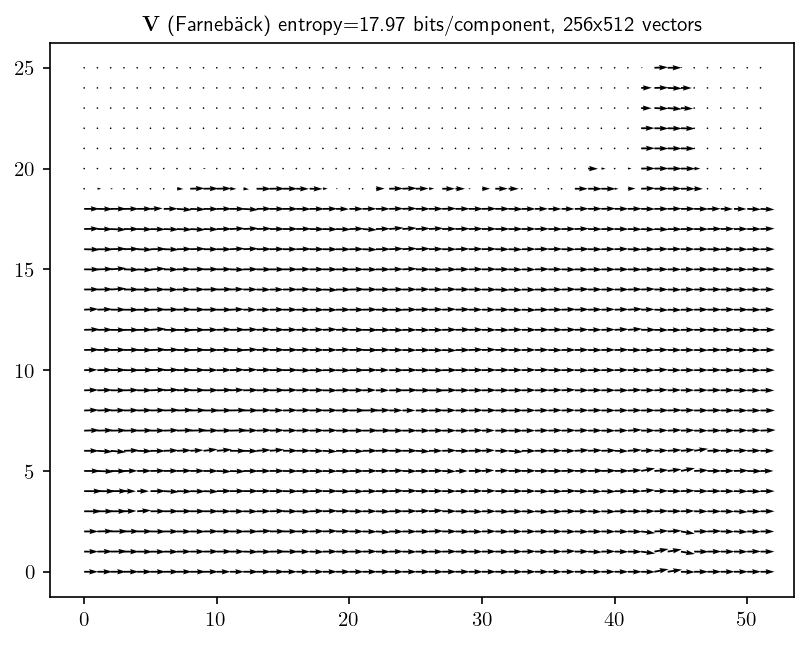

In [43]:
entropy = information.entropy(MVs.flatten())
display.show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

[image_3.py:87 print_stats() INFO] component=0 max=254 min=0 avg=108.20100402832031
[image_3.py:87 print_stats() INFO] component=1 max=243 min=0 avg=93.01155090332031
[image_3.py:87 print_stats() INFO] component=2 max=232 min=0 avg=76.66618347167969
[image_3.py:87 print_stats() INFO] component=0 max=227 min=10 avg=127.9944076538086
[image_3.py:87 print_stats() INFO] component=1 max=248 min=43 avg=128.05745697021484
[image_3.py:87 print_stats() INFO] component=2 max=244 min=69 avg=127.90385437011719


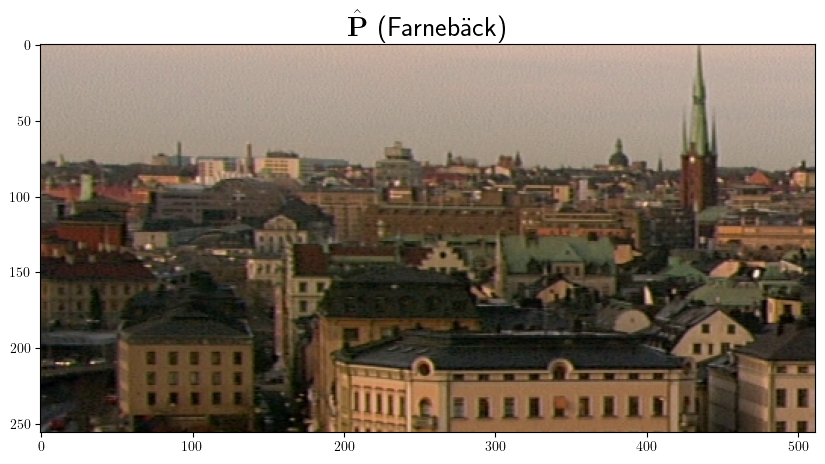

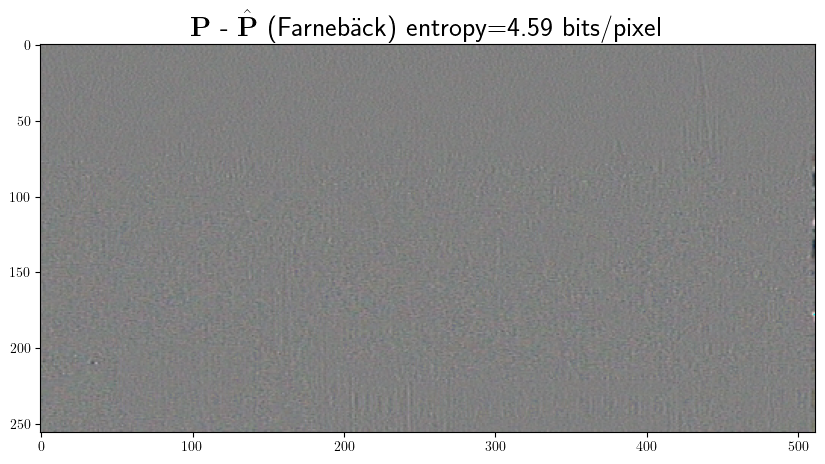

In [44]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
RGB_image.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.

## Another implementation
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [45]:
import numpy as np
import scipy.ndimage
from functools import partial
import skimage.io
import skimage.transform

__all__ = ["__version__", "poly_exp", "flow_iterative"]


__version__ = "1.0.0"


def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int32)
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    by = np.stack(
        [
            np.ones(a.shape),
            np.ones(a.shape),
            x,
            np.ones(a.shape),
            x**2,
            x,
        ],
        axis=-1,
    )

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, bx)
    abb = np.einsum("ij,ik->ijk", ab, bx)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f
    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)

    return A, B, C


def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
          
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

def OF(f1, f2): # f1 and f2 double's
    # certainties for images - certainty is decreased for pixels near the edge
    # of the image, as recommended by Farneback

    # c1 = np.ones_like(f1)
    # c2 = np.ones_like(f2)

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1
        / 5
        * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    # ---------------------------------------------------------------
    # calculate optical flow with this algorithm
    # ---------------------------------------------------------------

    n_pyr = 4

    # # version using perspective warp regularization
    # # to clean edges
    # opts = dict(
    #     sigma=4.0,
    #     sigma_flow=4.0,
    #     num_iter=3,
    #     model='eight_param',
    #     mu=None,
    # )

    # version using no regularization model
    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0,
    )

    # optical flow field
    d = None

    # calculate optical flow using pyramids
    # note: reversed(...) because we start with the smallest pyramid
    for pyr1, pyr2, c1_, c2_ in reversed(
        list(
            zip(
                *list(
                    map(
                        partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                        [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            # TODO: account for shapes not quite matching
            #d = skimage.transform.pyramid_expand(d, multichannel=True)
            d = skimage.transform.pyramid_expand(d, channel_axis=2)
            d = d[: pyr1.shape[0], : pyr2.shape[1]]

        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    xw = d + np.moveaxis(np.indices(f1.shape), 0, -1)
    return xw

In [46]:
MVs = OF(P_Y, R_Y)
f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), cval=np.nan)

G.shape = (16, 32, 6, 6)
v.shape = (16, 32, 6)
A.shape, B.shape, C.shape = (16, 32, 2, 2) (16, 32, 2) (16, 32)
G.shape = (16, 32, 6, 6)
v.shape = (16, 32, 6)
A.shape, B.shape, C.shape = (16, 32, 2, 2) (16, 32, 2) (16, 32)
G.shape = (32, 64, 6, 6)
v.shape = (32, 64, 6)
A.shape, B.shape, C.shape = (32, 64, 2, 2) (32, 64, 2) (32, 64)
G.shape = (32, 64, 6, 6)
v.shape = (32, 64, 6)
A.shape, B.shape, C.shape = (32, 64, 2, 2) (32, 64, 2) (32, 64)
G.shape = (64, 128, 6, 6)
v.shape = (64, 128, 6)
A.shape, B.shape, C.shape = (64, 128, 2, 2) (64, 128, 2) (64, 128)
G.shape = (64, 128, 6, 6)
v.shape = (64, 128, 6)
A.shape, B.shape, C.shape = (64, 128, 2, 2) (64, 128, 2) (64, 128)
G.shape = (128, 256, 6, 6)
v.shape = (128, 256, 6)
A.shape, B.shape, C.shape = (128, 256, 2, 2) (128, 256, 2) (128, 256)
G.shape = (128, 256, 6, 6)
v.shape = (128, 256, 6)
A.shape, B.shape, C.shape = (128, 256, 2, 2) (128, 256, 2) (128, 256)
G.shape = (256, 512, 6, 6)
v.shape = (256, 512, 6)
A.shape, B.shape, C.shape = (25

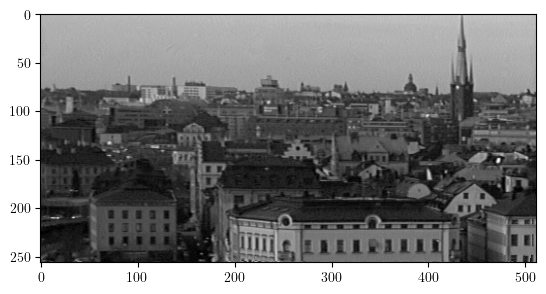

In [47]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)
plt.imshow(f2_w, cmap=cmap)

## Working with lines
Farneback requires at least 2 lines.

In [48]:
R = RGB_image.read(sequence + "003.png")[100:356,100:102]
P = RGB_image.read(sequence + "003.png")[100:356,102:104]

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0


In [49]:
R.shape

(256, 2, 3)

In [50]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [51]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

## Working with 1-d lines

In [52]:
R_Y_line = R_Y[10]
P_Y_line = P_Y[11]

In [53]:
print(R_Y_line.shape,P_Y_line.shape)

(2,) (2,)


## Farneback 1D

In [54]:
c = np.ones_like(R_Y_line)

In [55]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    x = np.arange(-n, n + 1, dtype=np.int32)
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print(b.shape)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape))
    v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b)
    abb = np.einsum("ij,ik->ijk", ab, b)

    # Calculate G and v for each pixel with cross-correlation
    for j in range(b.shape):
        G[..., j] = scipy.ndimage.correlate1d(
            c, abb[..., j], axis=0, mode="constant", cval=0
        )

    v = scipy.ndimage.correlate1d(
        cf, ab, axis=0, mode="constant", cval=0
    )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape))
    A[..., 0] = r[..., 2]

    # Linear term
    B = np.empty(list(f.shape))
    B[..., 0] = r[..., 1]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    return A, B, C


In [56]:
A_Y, B_Y, C_Y = poly_exp_1D(R_Y_line, c, sigma=1.0)

(11, 3)
G.shape = (2,)
v.shape = (2,)


TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
A_Y

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape